In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import random
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from math import sqrt
from decimal import Decimal
import eli5
import warnings
from eli5 import explain_weights, explain_prediction
warnings.filterwarnings('always', category=FutureWarning,
                        module='sklearn.utils.deprecation')
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LogisticRegression
import shap
import seaborn as sns
# import eli5
# from eli5.sklearn import PermutationImportance


/Users/Soohwan/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Soohwan/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Function to parse df and test SVM model

In [2]:
def test_data(df, random_int):
    #get rid of medical terms and separate features and labels
    all_np=df.to_numpy().transpose()[0:].transpose()

    all_np = np.asarray(all_np).astype('float32')

    all_features=all_np[0:-1].transpose()
    all_labels=all_np[-1].transpose()

    print(all_features.shape)
    print(all_features)

    print(all_labels.shape)
    print(all_labels)
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=200, random_state=random_int)

    avg_auc=0
    avg_auc_interval=0

    avg_accuracy=0
    avg_accuracy_interval=0

    avg_precision=0
    avg_precision_interval=0

    avg_sensitivity=0
    avg_sensitivity_interval=0

    avg_specificity=0
    avg_specificity_interval=0

    k=0


    for train_index, test_index in rskf.split(all_features, all_labels):

        X_train, X_test = all_features[train_index], all_features[test_index]
        y_train, y_test = all_labels[train_index], all_labels[test_index]

        clf=svm.SVC(probability=True)
        y_pred = clf.fit(X_train, y_train).predict(X_test)

        #Calculate necessary metrics
        accuracy=accuracy_score(y_test, y_pred)
        precision=precision_score(y_test, y_pred, average='macro')

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)

        auc=roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

        #Calculate Intervals
        accuracy_interval = 1.96 * sqrt((accuracy*(1-accuracy))/ len(y_test))
        precision_interval = 1.96 * sqrt((precision*(1-precision))/ len(y_test))
        specificity_interval = 1.96 * sqrt((specificity*(1-specificity))/ len(y_test))
        sensitivity_interval = 1.96 * sqrt((sensitivity*(1-sensitivity))/ len(y_test))
        auc_interval = 1.96 * sqrt((auc*(1-auc))/ len(y_test))

        #Add to to-be-averaged values
        avg_accuracy=avg_accuracy+accuracy
        avg_accuracy_interval=avg_accuracy_interval+accuracy_interval

        avg_precision=avg_precision+precision
        avg_precision_interval=avg_precision_interval+precision_interval

        avg_specificity=avg_specificity+specificity
        avg_specificity_interval=avg_specificity_interval+specificity_interval

        avg_sensitivity=avg_sensitivity+sensitivity
        avg_sensitivity_interval=avg_sensitivity_interval+sensitivity_interval

        avg_auc=avg_auc+auc
        avg_auc_interval=avg_auc_interval+auc_interval

        k=k+1

    print("TEST:", test_index)
    print("After "+ str(k) + " runs")

    avg_accuracy=round(Decimal(avg_accuracy/k),2)
    avg_accuracy_interval=round(Decimal(avg_accuracy_interval/k),2)
    avg_precision=round(Decimal(avg_precision/k),2)
    avg_precision_interval=round(Decimal(avg_precision_interval/k),2)
    avg_specificity=round(Decimal(avg_specificity/k),2)
    avg_specificity_interval=round(Decimal(avg_specificity_interval/k),2)
    avg_sensitivity=round(Decimal(avg_sensitivity/k),2)
    avg_sensitivity_interval=round(Decimal(avg_sensitivity_interval/k),2)
    avg_auc=round(Decimal(avg_auc/k),2)
    avg_auc_interval=round(Decimal(avg_auc_interval/k),2)

    print("Accuracy: \t" + str(avg_accuracy) +
          " [" + str((avg_accuracy)-(avg_accuracy_interval)) +"-"+
          str((avg_accuracy)+(avg_accuracy_interval)) + "]\n")

    print("Precison: \t" + str(avg_precision) +
          " [" + str((avg_precision)-(avg_precision_interval)) +"-"+
          str((avg_precision)+(avg_precision_interval)) + "]\n")

    print("Specificity: \t" + str(avg_specificity) +
          " [" + str((avg_specificity)-(avg_specificity_interval)) +"-"+
          str((avg_specificity)+(avg_specificity_interval)) + "]\n")

    print("Sensitivity: \t" + str(avg_sensitivity) +
          " [" + str((avg_sensitivity)-(avg_sensitivity_interval)) +"-"+
          str((avg_sensitivity)+(avg_sensitivity_interval)) + "]\n")

    print("AUC: \t\t" + str(avg_auc) +
          " [" + str((avg_auc)-(avg_auc_interval)) +"-"+
          str((avg_auc)+(avg_auc_interval)) + "]")

    print("=====================================")
    return avg_accuracy,avg_auc

# Assess base performance with all features

In [3]:
# import excel sheet to pandas dataframe
rows_to_keep = np.arange(323)
df=pd.read_excel(open('../Data/SPS-Commorbiditiesver6.xlsx', 'rb'), index_col=0,sheet_name='Reorganized-with-labels (2)',skiprows = lambda x: x not in rows_to_keep, usecols=range(50))
df = df.drop(labels='Total', axis=1)

df

,1,2,3,7,8,9,10,11,12,13,...,46,47,48,49,50,51,52,53,54,55
Past medical history item,,,,,,,,,,,,,,,,,,,,,
(cv) aneurysm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(cv) aortic stenosis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(cv) aortoiliac occlusive disease,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(cv) atherosclerotic cardiovascular disease,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(cv) chest tightness or pressure,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
(rheum/immuno) inflammatory arthritis (unspecified),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(rheum/immuno) psoriasis,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(rheum/immuno) rheumatoid arthritis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data(df,362)

(48, 321)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.52 [0.32-0.72]

Precison: 	0.47 [0.28-0.66]

Specificity: 	0.74 [0.63-0.85]

Sensitivity: 	0.31 [0.19-0.43]

AUC: 		0.40 [0.21-0.59]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

(Decimal('0.52'), Decimal('0.40'))

# Feature Reduction

In [48]:
rows_to_keep = np.arange(323)
df=pd.read_excel(open('../Data/SPS-Commorbiditiesver6.xlsx', 'rb'), index_col=0,sheet_name='Reorganized-with-labels (2)',skiprows = lambda x: x not in rows_to_keep, usecols=range(50))

#remove rows with all 0's
df = df.loc[~(df==0).all(axis=1)]

#Remove symptoms that only appear once (feature selection)
df = df[df.Total!= 1]
df = df[df.Total!= 2]
df = df[df.Total!= 3]
# df = df[df.Total!= 4] --> would boost AUC

df = df.drop(labels='Total', axis=1)

df

,1,2,3,7,8,9,10,11,12,13,...,46,47,48,49,50,51,52,53,54,55
Past medical history item,,,,,,,,,,,,,,,,,,,,,
(cv) hypertension (unspecified),0,0,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
(endo) diabetes mellitus (unspecified),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(endo) dyslipidemia,0,0,1,1,0,0,0,0,0,0,...,1,1,0,0,0,1,1,0,1,0
(endo) Hashimoto's disease,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(endo) hypothyroidism (unspecified),0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
(endo) obesity,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
(endo) vitamin D deficiency,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(gi) dysphagia,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(gi) gastroesophageal reflux disease,0,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


### Vectorize Features and labels

In [49]:
#get rid of medical terms and separate features and labels
all_np=df.to_numpy().transpose()[0:].transpose()

all_np = np.asarray(all_np).astype('float32')

all_features=all_np[0:-1].transpose()
all_labels=all_np[-1].transpose()

print(all_features.shape)
print(all_features)

print(all_labels.shape)
print(all_labels)

(48, 27)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


## Extract SHAP & Permutation Importance Values

In [7]:
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=20, random_state=362)

avg_auc=0
avg_auc_interval=0

avg_accuracy=0
avg_accuracy_interval=0

avg_precision=0
avg_precision_interval=0

avg_sensitivity=0
avg_sensitivity_interval=0

avg_specificity=0
avg_specificity_interval=0

k=0

imp_np=np.zeros(27)

avg_shap_np_0=np.zeros((24,27))
avg_shap_np_1=np.zeros((24,27))


for train_index, test_index in rskf.split(all_features, all_labels):

    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    clf=svm.SVC(probability=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)

    #Calculate necessary metrics
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    auc=roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    #Calculate Intervals
    accuracy_interval = 1.96 * sqrt((accuracy*(1-accuracy))/ len(y_test))
    precision_interval = 1.96 * sqrt((precision*(1-precision))/ len(y_test))
    specificity_interval = 1.96 * sqrt((specificity*(1-specificity))/ len(y_test))
    sensitivity_interval = 1.96 * sqrt((sensitivity*(1-sensitivity))/ len(y_test))
    auc_interval = 1.96 * sqrt((auc*(1-auc))/ len(y_test))

    #Add to to-be-averaged values
    avg_accuracy=avg_accuracy+accuracy
    avg_accuracy_interval=avg_accuracy_interval+accuracy_interval

    avg_precision=avg_precision+precision
    avg_precision_interval=avg_precision_interval+precision_interval

    avg_specificity=avg_specificity+specificity
    avg_specificity_interval=avg_specificity_interval+specificity_interval

    avg_sensitivity=avg_sensitivity+sensitivity
    avg_sensitivity_interval=avg_sensitivity_interval+sensitivity_interval

    avg_auc=avg_auc+auc
    avg_auc_interval=avg_auc_interval+auc_interval

    r = permutation_importance(clf, X_test, y_test,n_repeats=30,random_state=0)
    imp_np=imp_np+r.importances_mean
    
    explainer = shap.KernelExplainer(clf.predict_proba, X_train, link="logit")
    shap_values = explainer.shap_values(X_test)
    
    avg_shap_np_0=avg_shap_np_0+shap_values[0]
    avg_shap_np_1=avg_shap_np_1+shap_values[1]
    
    k=k+1

print("TEST:", test_index)
print("After "+ str(k) + " runs")

avg_accuracy=round(Decimal(avg_accuracy/k),2)
avg_accuracy_interval=round(Decimal(avg_accuracy_interval/k),2)
avg_precision=round(Decimal(avg_precision/k),2)
avg_precision_interval=round(Decimal(avg_precision_interval/k),2)
avg_specificity=round(Decimal(avg_specificity/k),2)
avg_specificity_interval=round(Decimal(avg_specificity_interval/k),2)
avg_sensitivity=round(Decimal(avg_sensitivity/k),2)
avg_sensitivity_interval=round(Decimal(avg_sensitivity_interval/k),2)
avg_auc=round(Decimal(avg_auc/k),2)
avg_auc_interval=round(Decimal(avg_auc_interval/k),2)

avg_shap_np_0=avg_shap_np_0/k
avg_shap_np_1=avg_shap_np_1/k


print("Accuracy: \t" + str(avg_accuracy) +
      " [" + str((avg_accuracy)-(avg_accuracy_interval)) +"-"+
      str((avg_accuracy)+(avg_accuracy_interval)) + "]\n")

print("Precison: \t" + str(avg_precision) +
      " [" + str((avg_precision)-(avg_precision_interval)) +"-"+
      str((avg_precision)+(avg_precision_interval)) + "]\n")

print("Specificity: \t" + str(avg_specificity) +
      " [" + str((avg_specificity)-(avg_specificity_interval)) +"-"+
      str((avg_specificity)+(avg_specificity_interval)) + "]\n")

print("Sensitivity: \t" + str(avg_sensitivity) +
      " [" + str((avg_sensitivity)-(avg_sensitivity_interval)) +"-"+
      str((avg_sensitivity)+(avg_sensitivity_interval)) + "]\n")

print("AUC: \t\t" + str(avg_auc) +
      " [" + str((avg_auc)-(avg_auc_interval)) +"-"+
      str((avg_auc)+(avg_auc_interval)) + "]")

print("=====================================")

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

TEST: [ 0  2  4  5  8 11 12 16 17 18 19 21 23 28 29 30 35 37 38 40 42 44 46 47]
After 40 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.70 [0.54-0.86]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.48 [0.29-0.67]


### Extract SHAP and PM Values with a higher split and higher repeats

In [51]:
rskf = RepeatedStratifiedKFold(n_splits=6, n_repeats=200, random_state=362)

avg_auc=0
avg_auc_interval=0

avg_accuracy=0
avg_accuracy_interval=0

avg_precision=0
avg_precision_interval=0

avg_sensitivity=0
avg_sensitivity_interval=0

avg_specificity=0
avg_specificity_interval=0

k=0

imp_np_2=np.zeros(27)

avg_shap_np_0_2=np.zeros((8,27))
avg_shap_np_1_2=np.zeros((8,27))


for train_index, test_index in rskf.split(all_features, all_labels):

    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    clf=svm.SVC(probability=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)

    #Calculate necessary metrics
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    auc=roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    #Calculate Intervals
    accuracy_interval = 1.96 * sqrt((accuracy*(1-accuracy))/ len(y_test))
    precision_interval = 1.96 * sqrt((precision*(1-precision))/ len(y_test))
    specificity_interval = 1.96 * sqrt((specificity*(1-specificity))/ len(y_test))
    sensitivity_interval = 1.96 * sqrt((sensitivity*(1-sensitivity))/ len(y_test))
    auc_interval = 1.96 * sqrt((auc*(1-auc))/ len(y_test))

    #Add to to-be-averaged values
    avg_accuracy=avg_accuracy+accuracy
    avg_accuracy_interval=avg_accuracy_interval+accuracy_interval

    avg_precision=avg_precision+precision
    avg_precision_interval=avg_precision_interval+precision_interval

    avg_specificity=avg_specificity+specificity
    avg_specificity_interval=avg_specificity_interval+specificity_interval

    avg_sensitivity=avg_sensitivity+sensitivity
    avg_sensitivity_interval=avg_sensitivity_interval+sensitivity_interval

    avg_auc=avg_auc+auc
    avg_auc_interval=avg_auc_interval+auc_interval

    r = permutation_importance(clf, X_test, y_test,n_repeats=30,random_state=0)
    imp_np_2=imp_np_2+r.importances_mean
    
    explainer = shap.KernelExplainer(clf.predict_proba, X_train, link="logit")
    shap_values = explainer.shap_values(X_test)
    
    avg_shap_np_0_2=avg_shap_np_0_2+shap_values[0]
    avg_shap_np_1_2=avg_shap_np_1_2+shap_values[1]
    
    k=k+1

print("TEST:", test_index)
print("After "+ str(k) + " runs")

avg_accuracy=round(Decimal(avg_accuracy/k),2)
avg_accuracy_interval=round(Decimal(avg_accuracy_interval/k),2)
avg_precision=round(Decimal(avg_precision/k),2)
avg_precision_interval=round(Decimal(avg_precision_interval/k),2)
avg_specificity=round(Decimal(avg_specificity/k),2)
avg_specificity_interval=round(Decimal(avg_specificity_interval/k),2)
avg_sensitivity=round(Decimal(avg_sensitivity/k),2)
avg_sensitivity_interval=round(Decimal(avg_sensitivity_interval/k),2)
avg_auc=round(Decimal(avg_auc/k),2)
avg_auc_interval=round(Decimal(avg_auc_interval/k),2)

avg_shap_np_0_2=avg_shap_np_0_2/k
avg_shap_np_1_2=avg_shap_np_1_2/k


print("Accuracy: \t" + str(avg_accuracy) +
      " [" + str((avg_accuracy)-(avg_accuracy_interval)) +"-"+
      str((avg_accuracy)+(avg_accuracy_interval)) + "]\n")

print("Precison: \t" + str(avg_precision) +
      " [" + str((avg_precision)-(avg_precision_interval)) +"-"+
      str((avg_precision)+(avg_precision_interval)) + "]\n")

print("Specificity: \t" + str(avg_specificity) +
      " [" + str((avg_specificity)-(avg_specificity_interval)) +"-"+
      str((avg_specificity)+(avg_specificity_interval)) + "]\n")

print("Sensitivity: \t" + str(avg_sensitivity) +
      " [" + str((avg_sensitivity)-(avg_sensitivity_interval)) +"-"+
      str((avg_sensitivity)+(avg_sensitivity_interval)) + "]\n")

print("AUC: \t\t" + str(avg_auc) +
      " [" + str((avg_auc)-(avg_auc_interval)) +"-"+
      str((avg_auc)+(avg_auc_interval)) + "]")

print("=====================================")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

TEST: [ 1  6 25 31 35 37 38 46]
After 1200 runs
Accuracy: 	0.69 [0.39-0.99]

Precison: 	0.71 [0.43-0.99]

Specificity: 	0.72 [0.49-0.95]

Sensitivity: 	0.65 [0.40-0.90]

AUC: 		0.61 [0.34-0.88]


# Visualize SHAP and Permutation Importance Scores

In [8]:
# Initialize Ordered Features
feature_array=df.T.columns.tolist()[0:-1]
feature_array

['(cv) hypertension (unspecified)',
 '(endo) diabetes mellitus (unspecified)',
 '(endo) dyslipidemia',
 "(endo) Hashimoto's disease",
 '(endo) hypothyroidism (unspecified)',
 '(endo) obesity',
 '(endo) vitamin D deficiency',
 '(gi) dysphagia',
 '(gi) gastroesophageal reflux disease',
 '(id) urinary tract infection, recurrent',
 '(msk) pain, joint (unspecified)',
 '(msk) pain, knee (unspecified)',
 '(nephro/uro) kidney disease, chronic',
 '(neuro) abnormal involuntary movement',
 '(neuro) headache (unspecified)',
 '(neuro) migraine',
 '(neuro) pain, back (unspecified)',
 '(neuro) peripheral neuropathy (unspecified)',
 '(neuro) seizure (unspecified)',
 '(ophth) diplopia',
 '(psych) anxiety (unspecified)',
 '(psych) attention deficit hyperactivity disorder',
 '(psych) depression (unspecified)',
 '(psych) major depressive disorder',
 '(psych) post traumatic stress disorder',
 '(resp) asthma',
 '(resp) obstructive sleep apnea']

### SHAP

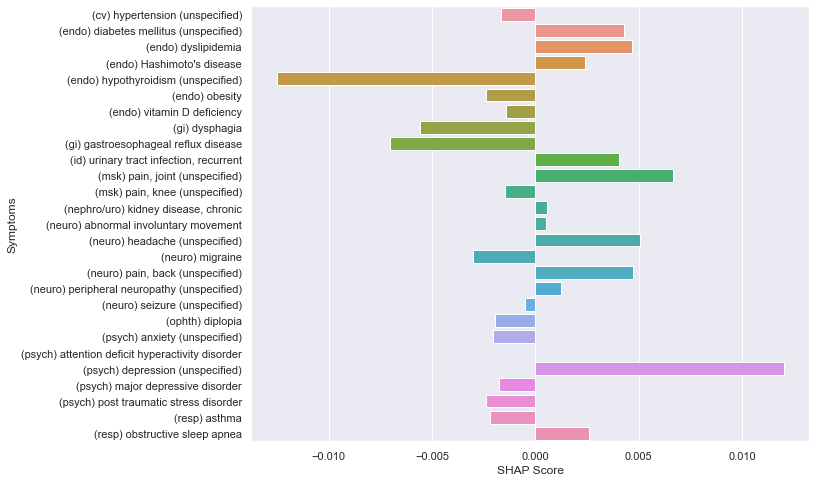

In [12]:
sum_avg_shap_np_0=np.zeros(27)
for i in range(avg_shap_np_0.shape[0]):
    sum_avg_shap_np_0=sum_avg_shap_np_0+avg_shap_np_0[i]
sum_avg_shap_np_0=sum_avg_shap_np_0/avg_shap_np_0.shape[0]

sum_avg_shap_np_1=np.zeros(27)
for i in range(avg_shap_np_1.shape[0]):
    sum_avg_shap_np_1=sum_avg_shap_np_1+avg_shap_np_1[i]
sum_avg_shap_np_1=sum_avg_shap_np_1/avg_shap_np_1.shape[0]

# sns.set(rc={'figure.figsize':(10,13)})
# fig, axes = plt.subplots(2, 1)
# axes[0].set_title("Class 0")
# axes[1].set_title("Class 1")
# sns.barplot(ax=axes[0],y=feature_array,x=sum_avg_shap_np_0)
# sns.barplot(ax=axes[1],y=feature_array,x=sum_avg_shap_np_1)

sns.set(rc={'figure.figsize':(10,8)})
fig, axes = plt.subplots(1, 1)
axes.set(xlabel='SHAP Score')
axes.set(ylabel='Symptoms')

sns.barplot(ax=axes,y=feature_array,x=sum_avg_shap_np_0)

fig.savefig("../results/figures/shap_scores.png",bbox_inches = "tight")


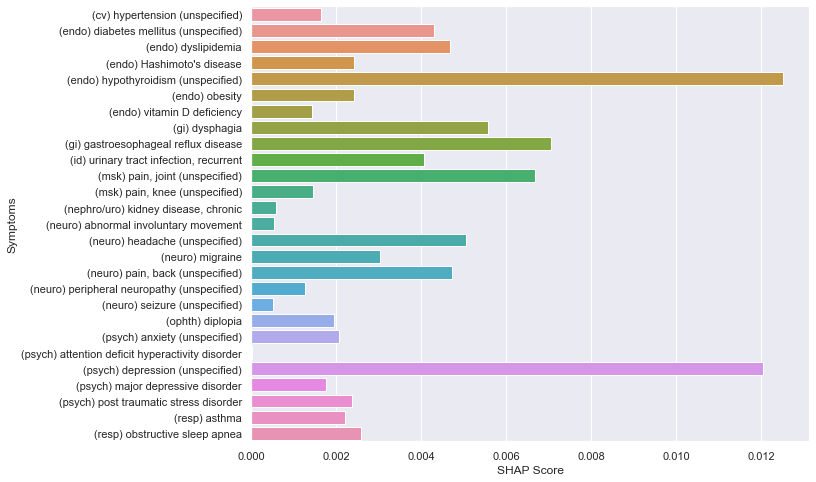

In [40]:
sns.set(rc={'figure.figsize':(10,8)})
fig, axes = plt.subplots(1, 1)
axes.set(xlabel='SHAP Score')
axes.set(ylabel='Symptoms')

sns.barplot(ax=axes,y=feature_array,x=np.abs(sum_avg_shap_np_0))
fig.savefig("../results/figures/abs_shap_scores.png",bbox_inches = "tight")


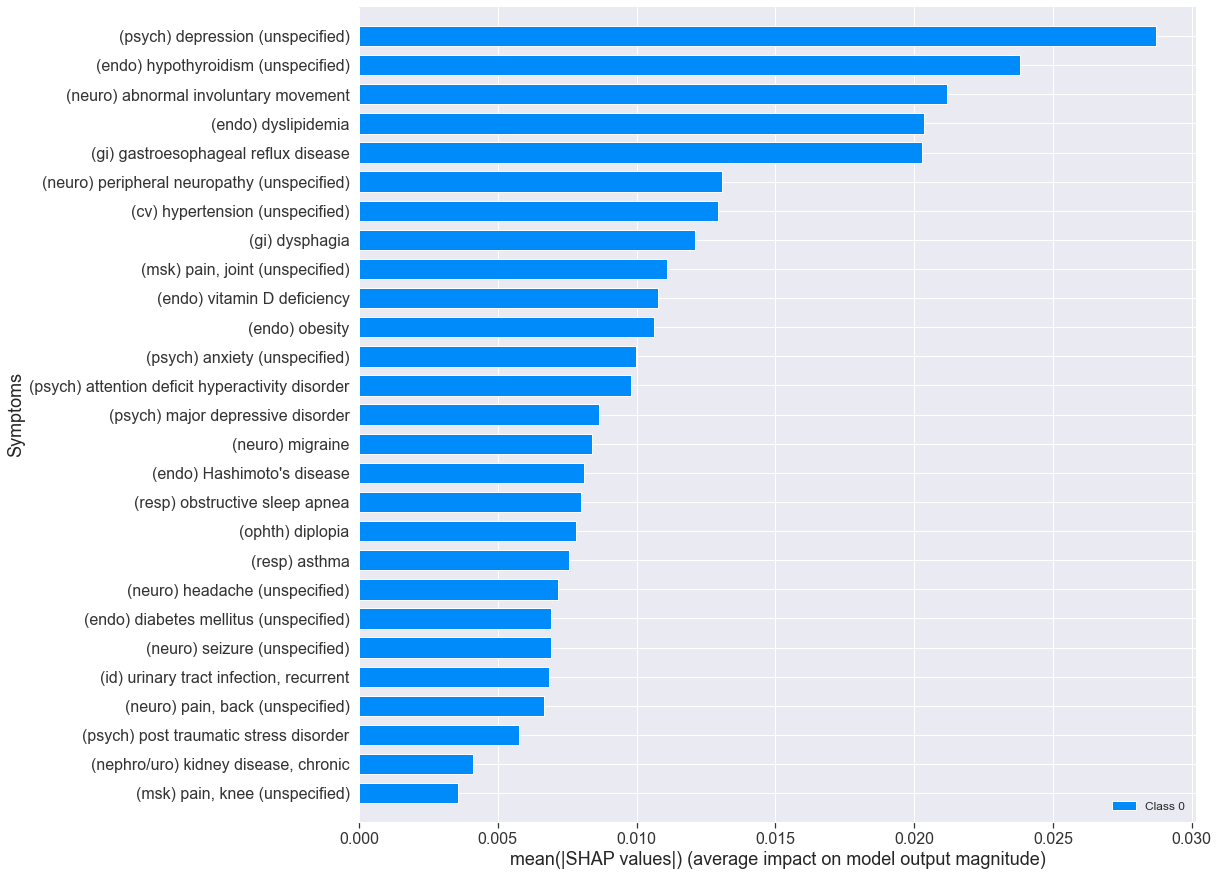

In [15]:
plt.gcf()
shap.summary_plot([avg_shap_np_0], feature_array,max_display=100,plot_size=(15, 15),show=False)

plt.xlabel('mean(|SHAP values|) (average impact on model output magnitude)',fontsize=18)
plt.ylabel('Symptoms',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# get_legend().remove()


plt.savefig("../results/figures/feature_importance/original_shap_output.png",bbox_inches = "tight")

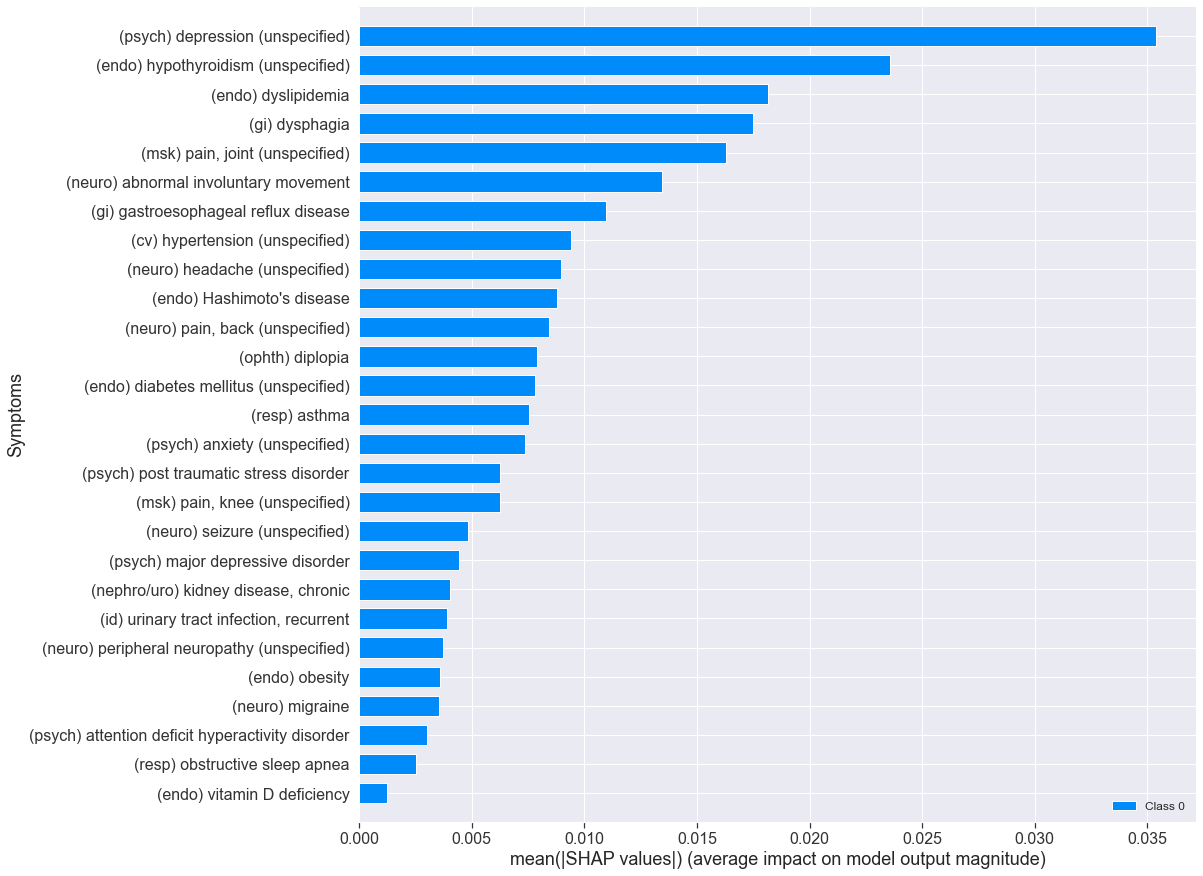

In [54]:
plt.gcf()
shap.summary_plot([avg_shap_np_0_2], feature_array,max_display=100,plot_size=(15, 15),show=False)

plt.xlabel('mean(|SHAP values|) (average impact on model output magnitude)',fontsize=18)
plt.ylabel('Symptoms',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# get_legend().remove()
plt.savefig("../results/figures/feature_importance/original_2_shap_output.png",bbox_inches = "tight")

## Permutation Importance

In [69]:
#Sort them in order of their importance
sorted_imp_np=np.sort(imp_np)
sorted_imp_np

array([-6.56944444e-01, -3.91666667e-01, -1.75000000e-01, -1.37500000e-01,
       -1.22222222e-01, -1.15277778e-01, -1.02777778e-01, -9.86111111e-02,
       -9.16666667e-02, -8.75000000e-02, -2.08333333e-02, -2.77555756e-17,
        9.72222222e-03,  1.11111111e-02,  3.61111111e-02,  6.66666667e-02,
        1.00000000e-01,  1.29166667e-01,  4.54166667e-01,  4.61111111e-01,
        5.48611111e-01,  5.65277778e-01,  5.94444444e-01,  7.48611111e-01,
        8.70833333e-01,  9.34722222e-01,  2.76805556e+00])

In [70]:
#sort features by importance

features_sorted=[]

for i in sorted_imp_np:
    print(i)
    index = np.where(imp_np == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    features_sorted.append(feature_array[index[0][0]])

features_sorted

-0.6569444444444444
0
(cv) hypertension (unspecified)
-0.3916666666666668
12
(nephro/uro) kidney disease, chronic
-0.17500000000000007
23
(psych) major depressive disorder
-0.1375000000000001
17
(neuro) peripheral neuropathy (unspecified)
-0.1222222222222224
13
(neuro) abnormal involuntary movement
-0.11527777777777785
3
(endo) Hashimoto's disease
-0.10277777777777802
5
(endo) obesity
-0.09861111111111119
11
(msk) pain, knee (unspecified)
-0.09166666666666658
24
(psych) post traumatic stress disorder
-0.08750000000000005
25
(resp) asthma
-0.02083333333333329
16
(neuro) pain, back (unspecified)
-2.7755575615628914e-17
15
(neuro) migraine
0.00972222222222223
26
(resp) obstructive sleep apnea
0.011111111111110964
18
(neuro) seizure (unspecified)
0.03611111111111108
21
(psych) attention deficit hyperactivity disorder
0.06666666666666671
9
(id) urinary tract infection, recurrent
0.09999999999999996
6
(endo) vitamin D deficiency
0.12916666666666665
19
(ophth) diplopia
0.45416666666666655
8
(

['(cv) hypertension (unspecified)',
 '(nephro/uro) kidney disease, chronic',
 '(psych) major depressive disorder',
 '(neuro) peripheral neuropathy (unspecified)',
 '(neuro) abnormal involuntary movement',
 "(endo) Hashimoto's disease",
 '(endo) obesity',
 '(msk) pain, knee (unspecified)',
 '(psych) post traumatic stress disorder',
 '(resp) asthma',
 '(neuro) pain, back (unspecified)',
 '(neuro) migraine',
 '(resp) obstructive sleep apnea',
 '(neuro) seizure (unspecified)',
 '(psych) attention deficit hyperactivity disorder',
 '(id) urinary tract infection, recurrent',
 '(endo) vitamin D deficiency',
 '(ophth) diplopia',
 '(gi) gastroesophageal reflux disease',
 '(endo) diabetes mellitus (unspecified)',
 '(psych) anxiety (unspecified)',
 '(endo) dyslipidemia',
 '(neuro) headache (unspecified)',
 '(endo) hypothyroidism (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(psych) depression (unspecified)']

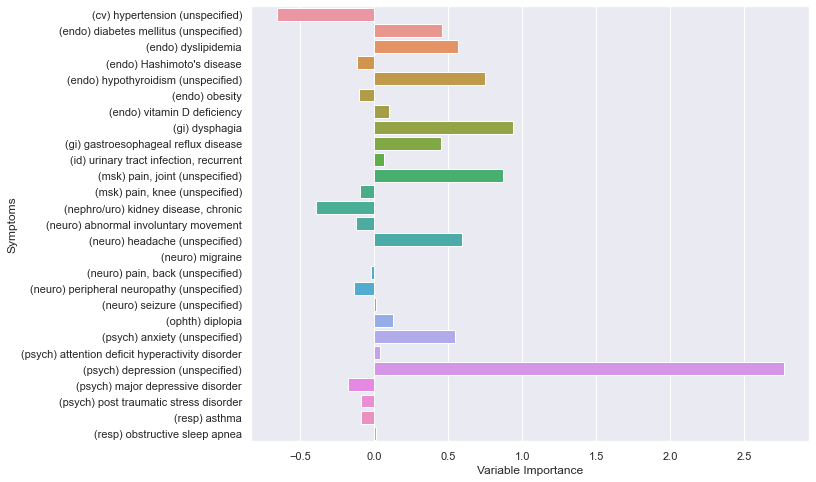

In [18]:
sns.set(rc={'figure.figsize':(10,8)})
fig, axes = plt.subplots(1, 1)
axes.set(xlabel='Variable Importance')
axes.set(ylabel='Symptoms')

sns.barplot(ax=axes,y=feature_array,x=imp_np)

fig.savefig("../results/figures/variable_importance_scores.png",bbox_inches = "tight")


#### Using Matplot

#### Positive / Negative

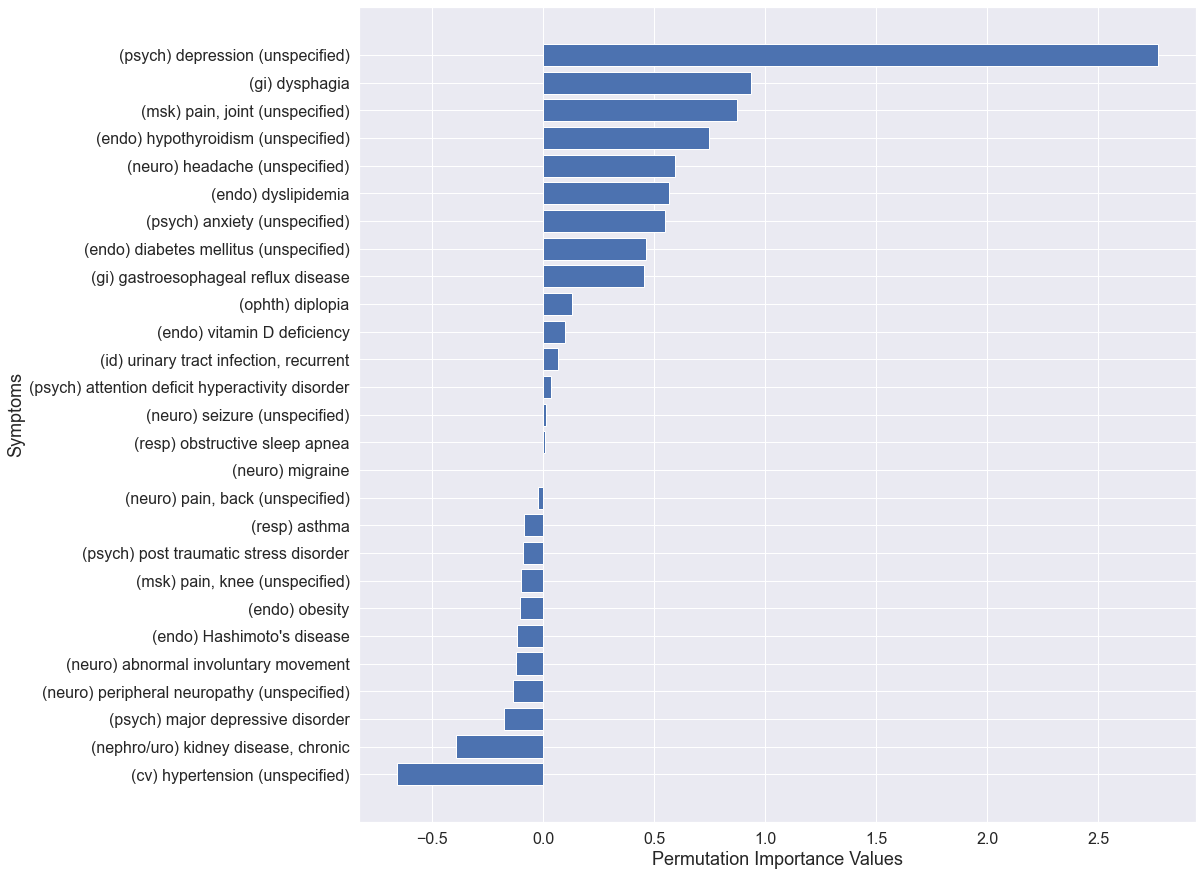

In [71]:
# plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(features_sorted, sorted_imp_np, align='center')
plt.style.use('ggplot')

plt.xlabel('Permutation Importance Values',fontsize=18,fontstyle='normal')
plt.ylabel('Symptoms',fontsize=18,fontstyle='normal')
plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
fig.set_size_inches(15, 15)

plt.show()
fig.savefig("../results/figures/feature_importance/variable_importance_scores.png",bbox_inches = "tight")

#### Absolute

In [23]:
imp_np_abs=np.abs(imp_np)

In [24]:
#Sort them in order of their importance
sorted_imp_np_abs=np.sort(imp_np_abs)
sorted_imp_np_abs

array([2.77555756e-17, 9.72222222e-03, 1.11111111e-02, 2.08333333e-02,
       3.61111111e-02, 6.66666667e-02, 8.75000000e-02, 9.16666667e-02,
       9.86111111e-02, 1.00000000e-01, 1.02777778e-01, 1.15277778e-01,
       1.22222222e-01, 1.29166667e-01, 1.37500000e-01, 1.75000000e-01,
       3.91666667e-01, 4.54166667e-01, 4.61111111e-01, 5.48611111e-01,
       5.65277778e-01, 5.94444444e-01, 6.56944444e-01, 7.48611111e-01,
       8.70833333e-01, 9.34722222e-01, 2.76805556e+00])

In [25]:
#sort features by importance

abs_perm_features_sorted=[]

for i in sorted_imp_np_abs:
    print(i)
    index = np.where(imp_np_abs == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    abs_perm_features_sorted.append(feature_array[index[0][0]])

abs_perm_features_sorted

2.7755575615628914e-17
15
(neuro) migraine
0.00972222222222223
26
(resp) obstructive sleep apnea
0.011111111111110964
18
(neuro) seizure (unspecified)
0.02083333333333329
16
(neuro) pain, back (unspecified)
0.03611111111111108
21
(psych) attention deficit hyperactivity disorder
0.06666666666666671
9
(id) urinary tract infection, recurrent
0.08750000000000005
25
(resp) asthma
0.09166666666666658
24
(psych) post traumatic stress disorder
0.09861111111111119
11
(msk) pain, knee (unspecified)
0.09999999999999996
6
(endo) vitamin D deficiency
0.10277777777777802
5
(endo) obesity
0.11527777777777785
3
(endo) Hashimoto's disease
0.1222222222222224
13
(neuro) abnormal involuntary movement
0.12916666666666665
19
(ophth) diplopia
0.1375000000000001
17
(neuro) peripheral neuropathy (unspecified)
0.17500000000000007
23
(psych) major depressive disorder
0.3916666666666668
12
(nephro/uro) kidney disease, chronic
0.45416666666666655
8
(gi) gastroesophageal reflux disease
0.46111111111111097
1
(endo) 

['(neuro) migraine',
 '(resp) obstructive sleep apnea',
 '(neuro) seizure (unspecified)',
 '(neuro) pain, back (unspecified)',
 '(psych) attention deficit hyperactivity disorder',
 '(id) urinary tract infection, recurrent',
 '(resp) asthma',
 '(psych) post traumatic stress disorder',
 '(msk) pain, knee (unspecified)',
 '(endo) vitamin D deficiency',
 '(endo) obesity',
 "(endo) Hashimoto's disease",
 '(neuro) abnormal involuntary movement',
 '(ophth) diplopia',
 '(neuro) peripheral neuropathy (unspecified)',
 '(psych) major depressive disorder',
 '(nephro/uro) kidney disease, chronic',
 '(gi) gastroesophageal reflux disease',
 '(endo) diabetes mellitus (unspecified)',
 '(psych) anxiety (unspecified)',
 '(endo) dyslipidemia',
 '(neuro) headache (unspecified)',
 '(cv) hypertension (unspecified)',
 '(endo) hypothyroidism (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(psych) depression (unspecified)']

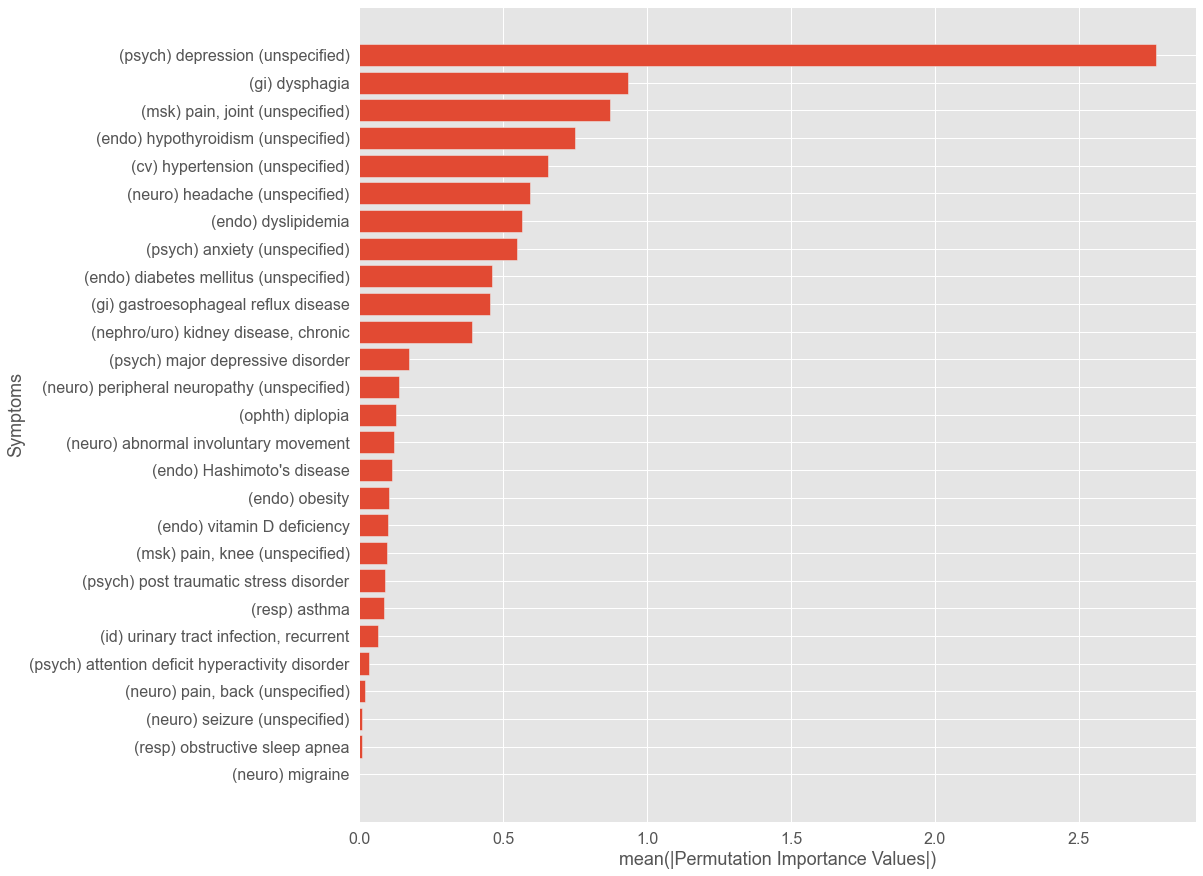

In [26]:
# plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(abs_perm_features_sorted, sorted_imp_np_abs, align='center')
plt.style.use('ggplot')

plt.xlabel('mean(|Permutation Importance Values|)',fontsize=18,fontstyle='normal')
plt.ylabel('Symptoms',fontsize=18,fontstyle='normal')
plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
fig.set_size_inches(15, 15)

plt.show()
fig.savefig("../results/figures/feature_importance/abs_variable_importance_scores.png",bbox_inches = "tight")

### Absolute (More folds and repeats)

In [59]:
imp_np_abs_2=np.abs(imp_np_2)

In [60]:
#Sort them in order of their importance
sorted_imp_np_abs_2=np.sort(imp_np_abs_2)
sorted_imp_np_abs_2

array([  0.4875    ,   0.92916667,   2.8625    ,   3.54166667,
         3.65      ,   4.42916667,   4.69583333,   4.72916667,
         5.07083333,   5.81666667,   6.05416667,   7.4875    ,
         7.58333333,   8.91666667,   9.02916667,   9.05833333,
         9.12916667,  10.92083333,  17.19583333,  18.5625    ,
        24.3875    ,  30.55      ,  33.30833333,  39.2625    ,
        42.6       ,  51.6625    , 112.06666667])

In [61]:
#sort features by importance

abs_perm_features_sorted_2=[]

for i in sorted_imp_np_abs_2:
    print(i)
    index = np.where(imp_np_abs_2 == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    abs_perm_features_sorted_2.append(feature_array[index[0][0]])

abs_perm_features_sorted_2

0.48749999999999993
24
(psych) post traumatic stress disorder
0.9291666666666665
9
(id) urinary tract infection, recurrent
2.862499999999997
6
(endo) vitamin D deficiency
3.5416666666666665
18
(neuro) seizure (unspecified)
3.65
23
(psych) major depressive disorder
4.429166666666666
13
(neuro) abnormal involuntary movement
4.69583333333333
17
(neuro) peripheral neuropathy (unspecified)
4.7291666666666625
26
(resp) obstructive sleep apnea
5.070833333333333
1
(endo) diabetes mellitus (unspecified)
5.81666666666667
12
(nephro/uro) kidney disease, chronic
6.054166666666671
21
(psych) attention deficit hyperactivity disorder
7.487499999999996
11
(msk) pain, knee (unspecified)
7.583333333333332
15
(neuro) migraine
8.916666666666668
3
(endo) Hashimoto's disease
9.029166666666656
19
(ophth) diplopia
9.058333333333334
5
(endo) obesity
9.12916666666666
16
(neuro) pain, back (unspecified)
10.920833333333336
25
(resp) asthma
17.19583333333333
4
(endo) hypothyroidism (unspecified)
18.562500000000014

['(psych) post traumatic stress disorder',
 '(id) urinary tract infection, recurrent',
 '(endo) vitamin D deficiency',
 '(neuro) seizure (unspecified)',
 '(psych) major depressive disorder',
 '(neuro) abnormal involuntary movement',
 '(neuro) peripheral neuropathy (unspecified)',
 '(resp) obstructive sleep apnea',
 '(endo) diabetes mellitus (unspecified)',
 '(nephro/uro) kidney disease, chronic',
 '(psych) attention deficit hyperactivity disorder',
 '(msk) pain, knee (unspecified)',
 '(neuro) migraine',
 "(endo) Hashimoto's disease",
 '(ophth) diplopia',
 '(endo) obesity',
 '(neuro) pain, back (unspecified)',
 '(resp) asthma',
 '(endo) hypothyroidism (unspecified)',
 '(cv) hypertension (unspecified)',
 '(psych) anxiety (unspecified)',
 '(neuro) headache (unspecified)',
 '(gi) gastroesophageal reflux disease',
 '(endo) dyslipidemia',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(psych) depression (unspecified)']

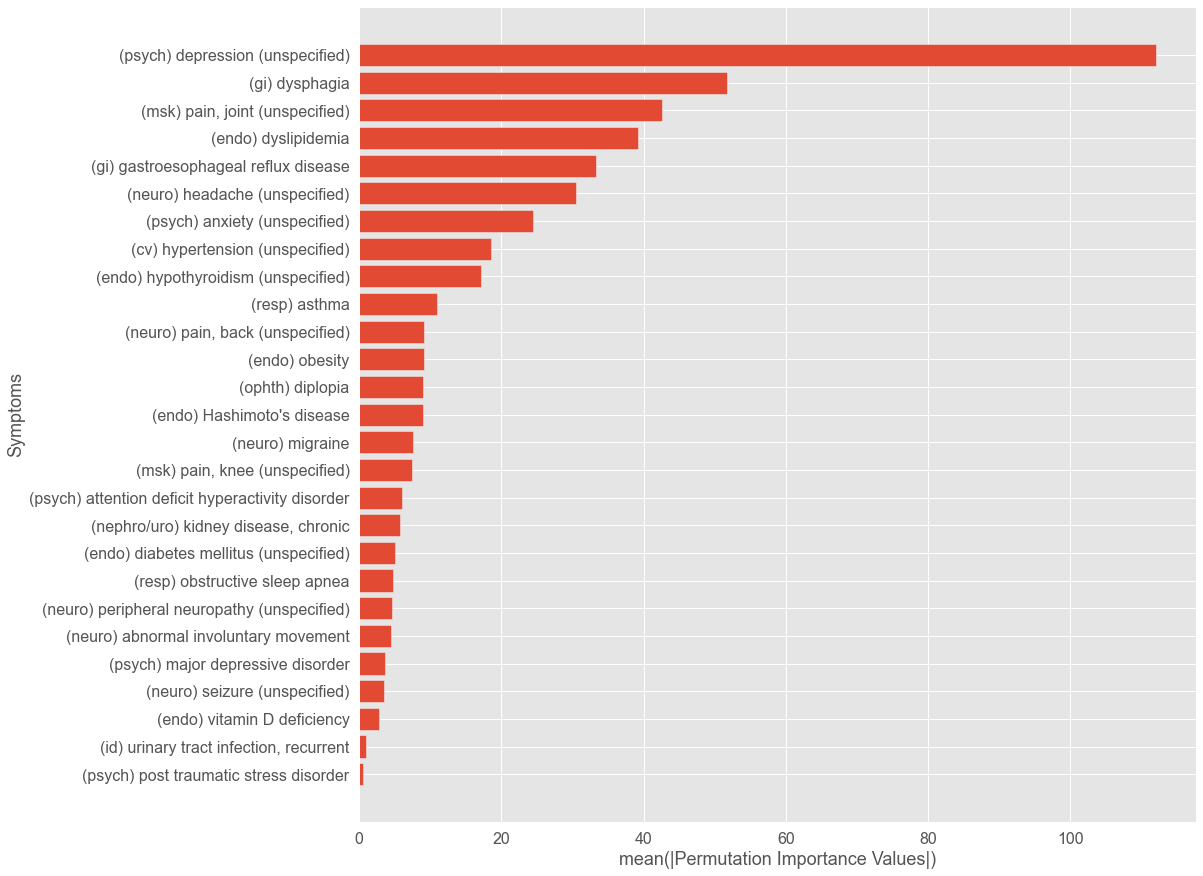

In [64]:
# plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(abs_perm_features_sorted_2, sorted_imp_np_abs_2, align='center')
plt.style.use('ggplot')

plt.xlabel('mean(|Permutation Importance Values|)',fontsize=18,fontstyle='normal')
plt.ylabel('Symptoms',fontsize=18,fontstyle='normal')
plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
fig.set_size_inches(15, 15)

plt.show()
fig.savefig("../results/figures/feature_importance/abs_variable_importance_scores_2.png",bbox_inches = "tight")

# Feature Filtering and Model Performance

### Permutation Importance (Positive/Negative)

In [68]:
# array of features in increasing importance, as obtained from scikit learn
features_sorted

['(cv) hypertension (unspecified)',
 '(nephro/uro) kidney disease, chronic',
 '(psych) major depressive disorder',
 '(neuro) peripheral neuropathy (unspecified)',
 '(neuro) abnormal involuntary movement',
 "(endo) Hashimoto's disease",
 '(endo) obesity',
 '(msk) pain, knee (unspecified)',
 '(psych) post traumatic stress disorder',
 '(resp) asthma',
 '(neuro) pain, back (unspecified)',
 '(neuro) migraine',
 '(resp) obstructive sleep apnea',
 '(neuro) seizure (unspecified)',
 '(psych) attention deficit hyperactivity disorder',
 '(id) urinary tract infection, recurrent',
 '(endo) vitamin D deficiency',
 '(ophth) diplopia',
 '(gi) gastroesophageal reflux disease',
 '(endo) diabetes mellitus (unspecified)',
 '(psych) anxiety (unspecified)',
 '(endo) dyslipidemia',
 '(neuro) headache (unspecified)',
 '(endo) hypothyroidism (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(psych) depression (unspecified)']

In [73]:
accuracy_array=[]
auc_array=[]

for i in range(len(features_sorted)):
    print("Building model with first " + str(i+1) + " features")
    to_include=features_sorted[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    accuracy_array.append(accuracy)
    auc_array.append(auc)

Building model with first 1 features
(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
Building model with first 2 features
(gi) dysphagia
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.82 [0.67-0.97]

Precison: 	0.84 [0.70-0.98]

Specificity: 	0.90 [0.80-1.00]

Sensitivity: 	0.73 [0.56-0.90]

AUC: 		0.83 [0.69-0.97]
Building model with first 8 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(48, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.78 [0.62-0.94]

Precison: 	0.79 [0.63-0.95]

Specificity: 	0.85 [0.73-0.97]

Sensitivity: 	0.70 [0.53-0.87]

AUC: 		0.79 [0.64-0.94]
Building model with first 12 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(48, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.75 [0.58-0.92]

Precison: 	0.77 [0.61-0.93]

Specificity: 	0.83 [0.70-0.96]

Sensitivity: 	0.67 [0.49-0.85]

AUC: 		0.70 [0.54-0.86]
Building model with first 15 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 15)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0.

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-0.89]

Precison: 	0.73 [0.56-0.90]

Specificity: 	0.78 [0.63-0.93]

Sensitivity: 	0.64 [0.46-0.82]

AUC: 		0.64 [0.47-0.81]
Building model with first 18 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(resp) asthma
(resp) obstructive sleep apnea
(48, 18)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.77 [0.62-0.92]

Sensitivity: 	0.60 [0.42-0.78]

AUC: 		0.58 [0.41-0.75]
Building model with first 21 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.68 [0.50-0.86]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.77 [0.62-0.92]

Sensitivity: 	0.57 [0.39-0.75]

AUC: 		0.55 [0.38-0.72]
Building model with first 22 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 22)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.56 [0.38-0.74]

AUC: 		0.52 [0.34-0.70]
Building model with first 25 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp)

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.49 [0.31-0.67]
Building model with first 26 features
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.48 [0.30-0.66]
Building model with first 27 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) ma

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.46 [0.27-0.65]


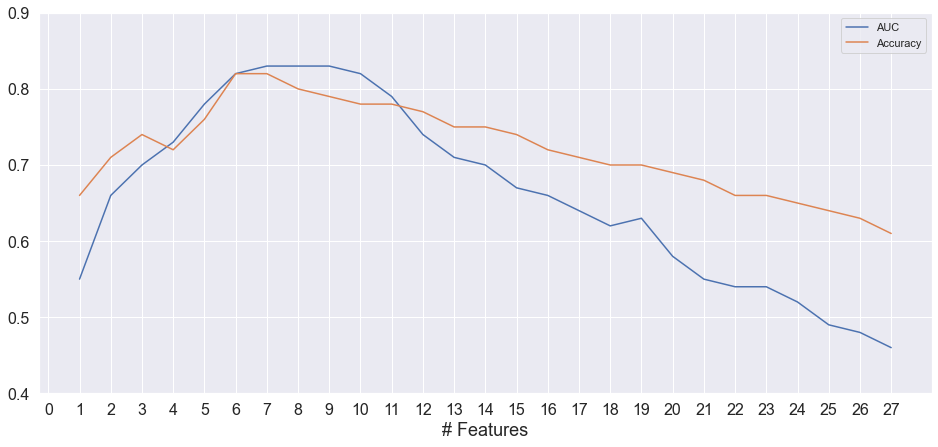

In [74]:
auc_array
sns.set(rc={'figure.figsize':(16,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
# g.set(xlabel='# Features',fontsize=18)
plt.xlabel('# Features',fontsize=18,fontstyle='normal')

plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
plt.ylim([.40, .90])

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/learning_curve/var_imp_learning_curve.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

### Absolute Permutation Importance

In [33]:
abs_perm_accuracy_array=[]
abs_perm_auc_array=[]

for i in range(len(abs_perm_features_sorted)):
    
    to_include=abs_perm_features_sorted[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    abs_perm_accuracy_array.append(accuracy)
    abs_perm_auc_array.append(auc)

(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
(gi) dysphagia
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.59 [0.40-0.78]

AUC: 		0.65 [0.47-0.83]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(psych) depression (unspecified)
(48, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.77 [0.61-0.93]

Precison: 	0.79 [0.63-0.95]

Specificity: 	0.84 [0.71-0.97]

Sensitivity: 	0.71 [0.54-0.88]

AUC: 		0.82 [0.68-0.96]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(48, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.72 [0.54-0.90]

Precison: 	0.74 [0.57-0.91]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.65 [0.47-0.83]

AUC: 		0.74 [0.58-0.90]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 14)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-0.89]

Precison: 	0.73 [0.56-0.90]

Specificity: 	0.80 [0.66-0.94]

Sensitivity: 	0.62 [0.44-0.80]

AUC: 		0.70 [0.54-0.86]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 15)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.77 [0.62-0.92]

Sensitivity: 	0.60 [0.42-0.78]

AUC: 		0.61 [0.44-0.78]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 18)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.49-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.77 [0.63-0.91]

Sensitivity: 	0.57 [0.39-0.75]

AUC: 		0.56 [0.38-0.74]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 20)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.49-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.56 [0.37-0.75]

AUC: 		0.56 [0.38-0.74]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.55 [0.37-0.73]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 22)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.49 [0.31-0.67]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.51 [0.33-0.69]

AUC: 		0.48 [0.30-0.66]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 24)

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.47 [0.29-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress d

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.51 [0.33-0.69]

AUC: 		0.48 [0.30-0.66]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress d

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post t

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]


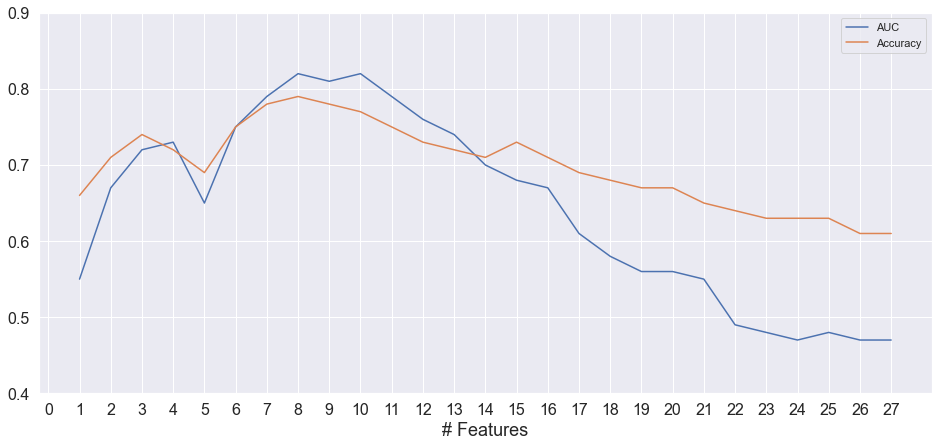

In [37]:
# auc_array
sns.set(rc={'figure.figsize':(16,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
# g.set(xlabel='# Features',fontsize=18)
plt.xlabel('# Features',fontsize=18,fontstyle='normal')

plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
plt.ylim([.40, .90])

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/learning_curve/abs_var_imp_learning_curve.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

### Absolute Permutation Importance with more folds and repeats

In [67]:
abs_perm_accuracy_array_2=[]
abs_perm_auc_array_2=[]

for i in range(len(abs_perm_features_sorted_2)):
    print("Building model with first " + str(i+1) + " features")
    to_include=abs_perm_features_sorted_2[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    abs_perm_accuracy_array_2.append(accuracy)
    abs_perm_auc_array_2.append(auc)

Building model with first 1 features
(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
Building model with first 2 features
(gi) dysphagia
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.77 [0.60-0.94]

Precison: 	0.79 [0.63-0.95]

Specificity: 	0.87 [0.76-0.98]

Sensitivity: 	0.66 [0.48-0.84]

AUC: 		0.76 [0.60-0.92]
Building model with first 8 features
(cv) hypertension (unspecified)
(endo) dyslipidemia
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(48, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0.

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.75 [0.58-0.92]

Precison: 	0.76 [0.59-0.93]

Specificity: 	0.80 [0.66-0.94]

Sensitivity: 	0.70 [0.53-0.87]

AUC: 		0.77 [0.62-0.92]
Building model with first 12 features
(cv) hypertension (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(resp) asthma
(48, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.70 [0.52-0.88]

Precison: 	0.72 [0.54-0.90]

Specificity: 	0.76 [0.61-0.91]

Sensitivity: 	0.64 [0.46-0.82]

AUC: 		0.70 [0.53-0.87]
Building model with first 15 features
(cv) hypertension (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(resp) asthma
(48, 15)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.48-0.86]

Precison: 	0.69 [0.51-0.87]

Specificity: 	0.75 [0.59-0.91]

Sensitivity: 	0.59 [0.41-0.77]

AUC: 		0.60 [0.43-0.77]
Building model with first 18 features
(cv) hypertension (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(resp) asthma
(48, 18)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.67 [0.48-0.86]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.56 [0.37-0.75]

AUC: 		0.55 [0.37-0.73]
Building model with first 21 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(resp) asthma
(resp) obstructive sleep apnea
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]
 ...
 [1. 0. 0. .

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.52 [0.34-0.70]
Building model with first 23 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 23)
[[0. 0. 0. ... 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.53 [0.35-0.71]

AUC: 		0.51 [0.33-0.69]
Building model with first 24 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(resp) asthma
(resp) obstructive sleep apnea

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.53 [0.35-0.71]

AUC: 		0.51 [0.33-0.69]
Building model with first 25 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(resp) asthma
(r

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.49 [0.31-0.67]
Building model with first 26 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) ma

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.50 [0.32-0.68]

AUC: 		0.48 [0.29-0.67]
Building model with first 27 features
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) ma

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]


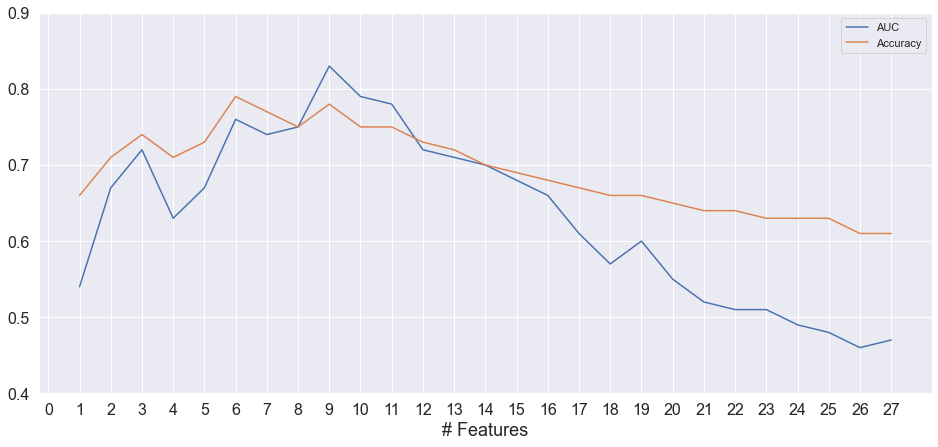

In [66]:
# auc_array
sns.set(rc={'figure.figsize':(16,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_auc_array_2)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_accuracy_array_2)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
# g.set(xlabel='# Features',fontsize=18)
plt.xlabel('# Features',fontsize=18,fontstyle='normal')

plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
plt.ylim([.40, .90])

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/learning_curve/abs_var_imp_learning_curve_2.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

## SHAP

In [38]:
shap_original_sorted=["(psych) depression (unspecified)",
                     "(endo) hypothyroidism (unspecified)",
                     "(gi) gastroesophageal reflux disease",
                     "(neuro) abnormal involuntary movement",
                     "(endo) dyslipidemia",
                      "(cv) hypertension (unspecified)",
                      "(endo) obesity",
                      "(gi) dysphagia",
                      "(psych) anxiety (unspecified)",
                      "(msk) pain, joint (unspecified)",
                      "(neuro) peripheral neuropathy (unspecified)",
                      "(neuro) migraine",
                      "(ophth) diplopia",
                      "(psych) attention deficit hyperactivity disorder",
                      "(neuro) pain, back (unspecified)",
                      "(psych) major depressive disorder",
                      "(resp) asthma",
                      "(endo) Hashimoto's disease",
                      "(resp) obstructive sleep apnea",
                      "(endo) diabetes mellitus (unspecified)",
                      "(neuro) headache (unspecified)",
                      "(psych) post traumatic stress disorder",
                      "(neuro) seizure (unspecified)",
                      "(endo) vitamin D deficiency",
                      "(id) urinary tract infection, recurrent",
                      "(msk) pain, knee (unspecified)",
                      "(nephro/uro) kidney disease, chronic"
                     ]

In [43]:
#with 2 fold, 20 repeats

shap_original_sorted_2=["(psych) depression (unspecified)",
                     "(endo) hypothyroidism (unspecified)",
                      "(neuro) abnormal involuntary movement",
                    "(endo) dyslipidemia",
                     "(gi) gastroesophageal reflux disease",
                      "(neuro) peripheral neuropathy (unspecified)",
                      "(cv) hypertension (unspecified)",
                      "(gi) dysphagia",
                      "(msk) pain, joint (unspecified)",
                      "(endo) vitamin D deficiency",
                      "(endo) obesity",
                      "(psych) anxiety (unspecified)",
                      "(psych) attention deficit hyperactivity disorder",
                      "(psych) major depressive disorder",
                      "(neuro) migraine",
                      "(endo) Hashimoto's disease",
                      "(resp) obstructive sleep apnea",
                      "(ophth) diplopia",
                      "(resp) asthma",
                      "(neuro) headache (unspecified)",
                      "(endo) diabetes mellitus (unspecified)",
                      "(neuro) seizure (unspecified)",
                      "(id) urinary tract infection, recurrent",
                      "(neuro) pain, back (unspecified)",
                      "(psych) post traumatic stress disorder",
                      "(nephro/uro) kidney disease, chronic",
                      "(msk) pain, knee (unspecified)",
                     ]

In [55]:
#with 6 fold, 200 repeats

shap_original_sorted_3=["(psych) depression (unspecified)",
                     "(endo) hypothyroidism (unspecified)",
                        "(endo) dyslipidemia",
                        "(gi) dysphagia",
                        "(msk) pain, joint (unspecified)",
                      "(neuro) abnormal involuntary movement",
                     "(gi) gastroesophageal reflux disease",
                        "(cv) hypertension (unspecified)",
                        "(neuro) headache (unspecified)",
                        "(endo) Hashimoto's disease",
                        "(neuro) pain, back (unspecified)",
                        "(ophth) diplopia",
                        "(endo) diabetes mellitus (unspecified)",
                        "(resp) asthma",
                        "(psych) anxiety (unspecified)",
                        "(psych) post traumatic stress disorder",
                        "(msk) pain, knee (unspecified)",
                        "(neuro) seizure (unspecified)",
                        "(psych) major depressive disorder",
                        "(nephro/uro) kidney disease, chronic",
                        "(id) urinary tract infection, recurrent",
                      "(neuro) peripheral neuropathy (unspecified)",
                      "(endo) obesity",
                        "(neuro) migraine",
                        "(psych) attention deficit hyperactivity disorder",
                        "(resp) obstructive sleep apnea",
                      "(endo) vitamin D deficiency"      
                     ]

In [44]:
# Check if they're indeed in feature array

print(len(shap_original_sorted_2))
for feature in shap_original_sorted_2:
    if (feature in feature_array):
        pass
    else:
        print(feature)

27


In [45]:
original_shap_accuracy_array=[]
original_shap_auc_array=[]

for i in range(len(shap_original_sorted_2)):
    to_include=shap_original_sorted_2[:1+i]
    print("Building model with first " + str(i+1) + " features")
    
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print("Including "+ feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    original_shap_accuracy_array.append(accuracy)
    original_shap_auc_array.append(auc)
    
    #     print(len(shap_original_sorted[:1+i]))

Building model with first 1 features
Including (psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
Building model with first 2 features
Including (endo) hypothyroidism (unspecified)
Including (psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.89 [0.82-0.96]

Sensitivity: 	0.33 [0.15-0.51]

AUC: 		0.51 [0.32-0.70]
Building model with first 3 features
Including (endo) hypothyroidism (unspecified)
Including (neuro) abnormal involuntary movement
Including (psych) depression (unspecified)
(48, 3)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]
 [1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.60 [0.41-0.79]

Precison: 	0.65 [0.47-0.83]

Specificity: 	0.84 [0.73-0.95]

Sensitivity: 	0.35 [0.17-0.53]

AUC: 		0.50 [0.31-0.69]
Building model with first 4 features
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (neuro) abnormal involuntary movement
Including (psych) depression (unspecified)
(48, 4)
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 0. 1.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 1.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.69 [0.51-0.87]

Specificity: 	0.82 [0.72-0.92]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.51 [0.32-0.70]
Building model with first 5 features
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (gi) gastroesophageal reflux disease
Including (neuro) abnormal involuntary movement
Including (psych) depression (unspecified)
(48, 5)
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.49-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.80 [0.68-0.92]

Sensitivity: 	0.53 [0.34-0.72]

AUC: 		0.56 [0.38-0.74]
Building model with first 7 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (gi) gastroesophageal reflux disease
Including (neuro) abnormal involuntary movement
Including (neuro) peripheral neuropathy (unspecified)
Including (psych) depression (unspecified)
(48, 7)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.78 [0.65-0.91]

Sensitivity: 	0.48 [0.29-0.67]

AUC: 		0.54 [0.36-0.72]
Building model with first 8 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (neuro) abnormal involuntary movement
Including (neuro) peripheral neuropathy (unspecified)
Including (psych) depression (unspecified)
(48, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.69 [0.51-0.87]

Specificity: 	0.76 [0.62-0.90]

Sensitivity: 	0.55 [0.36-0.74]

AUC: 		0.59 [0.42-0.76]
Building model with first 12 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) peripheral neuropathy (unspecified)
Including (psych) anxiety (unspecified)
Including (psych) depression (unspecified)
(48, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.68 [0.50-0.86]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.58 [0.40-0.76]

AUC: 		0.56 [0.39-0.73]
Building model with first 15 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Including (psych) depression (unspecified)
Including (psych) major depressive disorder
(48, 15)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.53 [0.35-0.71]

AUC: 		0.50 [0.32-0.68]
Building model with first 18 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Including (psych) depression (unspecified)
Including (psych) major depressive disorder
Including (resp) obstructive sleep apnea
(48, 1

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.72 [0.56-0.88]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.50 [0.32-0.68]
Building model with first 19 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Including (psych) depression (unspecified)
Including (psych) major depressive disorder
Including (resp) asthma
Including (resp) obstru

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.71 [0.55-0.87]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.49 [0.31-0.67]
Building model with first 20 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Including (psych) depression (unspecified)
Including (psych) major depressive disorder
Includ

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.53 [0.35-0.71]
Building model with first 21 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Including (psych) depression (unspecified)
I

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.49 [0.31-0.67]
Building model with first 22 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) attention deficit hyperactivity disorder
Incl

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.68 [0.50-0.86]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.49 [0.31-0.67]
Building model with first 23 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (ps

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.47-0.85]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.53 [0.35-0.71]

AUC: 		0.51 [0.33-0.69]
Building model with first 24 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (unspecified)
Including (ophth) diplopia
Including 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.51 [0.33-0.69]

AUC: 		0.48 [0.30-0.66]
Building model with first 27 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (un

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.46 [0.27-0.65]


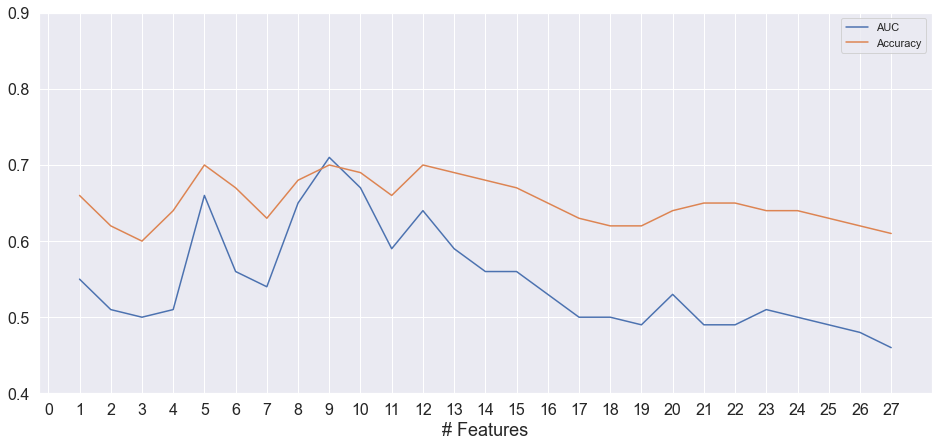

In [46]:
# auc_array
sns.set(rc={'figure.figsize':(16,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=original_shap_auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=original_shap_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
# g.set(xlabel='# Features',fontsize=18)
plt.xlabel('# Features',fontsize=18,fontstyle='normal')

plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
plt.ylim([.40, .90])

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/learning_curve/abs_shap_learning_curve.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

#### SHAP with more folds and repeats

In [56]:
# Check if they're indeed in feature array

print(len(shap_original_sorted_3))
for feature in shap_original_sorted_3:
    if (feature in feature_array):
        pass
    else:
        print(feature)

27


In [57]:
original_shap_accuracy_array_3=[]
original_shap_auc_array_3=[]

for i in range(len(shap_original_sorted_3)):
    to_include=shap_original_sorted_3[:1+i]
    print("Building model with first " + str(i+1) + " features")
    
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print("Including "+ feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    original_shap_accuracy_array_3.append(accuracy)
    original_shap_auc_array_3.append(auc)
    
    #     print(len(shap_original_sorted[:1+i]))

Building model with first 1 features
Including (psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
Building model with first 2 features
Including (endo) hypothyroidism (unspecified)
Including (psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.89 [0.82-0.96]

Sensitivity: 	0.33 [0.15-0.51]

AUC: 		0.52 [0.33-0.71]
Building model with first 3 features
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (psych) depression (unspecified)
(48, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
(48,)
[1. 1. 1. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.80 [0.71-0.89]

Sensitivity: 	0.40 [0.22-0.58]

AUC: 		0.48 [0.29-0.67]
Building model with first 4 features
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (psych) depression (unspecified)
(48, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.73 [0.55-0.91]

Precison: 	0.75 [0.58-0.92]

Specificity: 	0.80 [0.66-0.94]

Sensitivity: 	0.65 [0.47-0.83]

AUC: 		0.78 [0.63-0.93]
Building model with first 9 features
Including (cv) hypertension (unspecified)
Including (endo) dyslipidemia
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (psych) depression (unspecified)
(48, 9)
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.73 [0.56-0.90]

Precison: 	0.75 [0.58-0.92]

Specificity: 	0.79 [0.65-0.93]

Sensitivity: 	0.67 [0.49-0.85]

AUC: 		0.78 [0.63-0.93]
Building model with first 13 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) pain, back (unspecified)
Including (ophth) diplopia
Including (psych) depression (unspecified)
(48, 13)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.72 [0.54-0.90]

Precison: 	0.73 [0.56-0.90]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.69 [0.52-0.86]

AUC: 		0.75 [0.59-0.91]
Building model with first 16 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) pain, back (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) depression (unspecified)
Including (psych) post traumatic stress disorder
Including (resp) asthma
(48, 16)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.70 [0.52-0.88]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.66 [0.48-0.84]

AUC: 		0.71 [0.55-0.87]
Building model with first 19 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) pain, back (unspecified)
Including (neuro) seizure (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) depression (unspecified)
Including (psych) major depressive disorder
Including (psych) post traumatic str

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.68 [0.50-0.86]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.73 [0.57-0.89]

Sensitivity: 	0.63 [0.45-0.81]

AUC: 		0.65 [0.48-0.82]
Building model with first 21 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) pain, back (unspecified)
Including (neuro) seizure (unspecified)
Including (ophth) diplopia
Including (psych) anxiety (unspecified)
Including (psych) depressi

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.47-0.85]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.54 [0.36-0.72]
Building model with first 24 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.47-0.85]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.54 [0.36-0.72]

AUC: 		0.53 [0.35-0.71]
Building model with first 25 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.52 [0.34-0.70]
Building model with first 26 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (unspecified)
Including (neuro) seizure (

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.50 [0.32-0.68]

AUC: 		0.49 [0.31-0.67]
Building model with first 27 features
Including (cv) hypertension (unspecified)
Including (endo) diabetes mellitus (unspecified)
Including (endo) dyslipidemia
Including (endo) Hashimoto's disease
Including (endo) hypothyroidism (unspecified)
Including (endo) obesity
Including (endo) vitamin D deficiency
Including (gi) dysphagia
Including (gi) gastroesophageal reflux disease
Including (id) urinary tract infection, recurrent
Including (msk) pain, joint (unspecified)
Including (msk) pain, knee (unspecified)
Including (nephro/uro) kidney disease, chronic
Including (neuro) abnormal involuntary movement
Including (neuro) headache (unspecified)
Including (neuro) migraine
Including (neuro) pain, back (unspecified)
Including (neuro) peripheral neuropathy (un

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.46 [0.27-0.65]


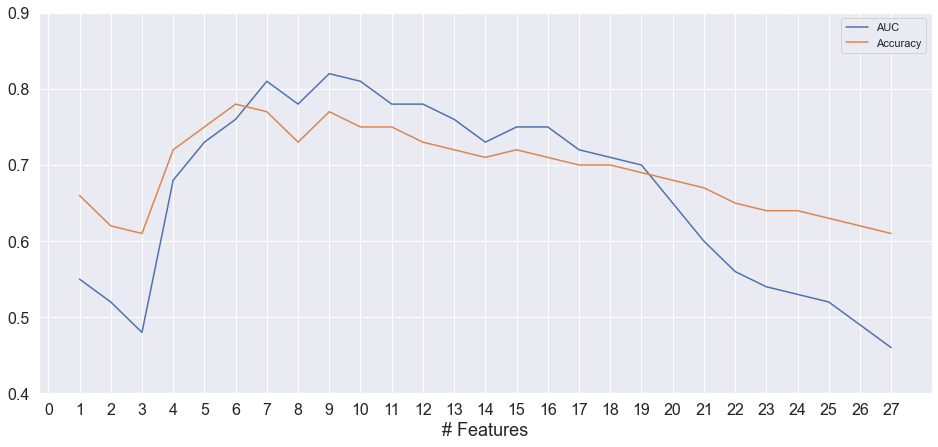

In [58]:
# auc_array
sns.set(rc={'figure.figsize':(16,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=original_shap_auc_array_3)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=original_shap_accuracy_array_3)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
# g.set(xlabel='# Features',fontsize=18)
plt.xlabel('# Features',fontsize=18,fontstyle='normal')

plt.yticks(fontsize=16,fontstyle='normal')
plt.xticks(fontsize=16,fontstyle='normal')
plt.ylim([.40, .90])

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/learning_curve/abs_shap_learning_curve_2.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

### My SHAP

#### Absolute SHAP

In [73]:
abs_shap=np.abs(sum_avg_shap_np_1)

In [74]:
#Sort them in order of their importance
sorted_abs_shap_np=np.sort(abs_shap)
sorted_abs_shap_np

array([6.91748039e-05, 1.86995954e-04, 4.63139188e-04, 5.72907975e-04,
       6.58703494e-04, 7.83594624e-04, 1.00839626e-03, 1.03287564e-03,
       1.57238658e-03, 1.87444425e-03, 2.09921968e-03, 2.22549906e-03,
       2.44221060e-03, 2.84834811e-03, 3.11318391e-03, 3.13588967e-03,
       3.44659859e-03, 3.57076738e-03, 3.58535909e-03, 3.79127093e-03,
       4.38493162e-03, 4.95916973e-03, 5.44896747e-03, 6.00909976e-03,
       7.83143557e-03, 1.30137471e-02, 1.32314497e-02])

In [80]:
#sort features by importance

features_sorted_abs_shap=[]

for i in sorted_abs_shap_np:
    print(i)
    index = np.where(abs_shap == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    features_sorted_abs_shap.append(feature_array[index[0][0]])

features_sorted_abs_shap

6.917480390506278e-05
13
(neuro) abnormal involuntary movement
0.00018699595372526385
9
(id) urinary tract infection, recurrent
0.00046313918821293157
2
(endo) dyslipidemia
0.0005729079754131098
12
(nephro/uro) kidney disease, chronic
0.0006587034943052691
3
(endo) Hashimoto's disease
0.0007835946243204975
17
(neuro) peripheral neuropathy (unspecified)
0.0010083962553800211
1
(endo) diabetes mellitus (unspecified)
0.0010328756439105054
18
(neuro) seizure (unspecified)
0.0015723865778634544
19
(ophth) diplopia
0.0018744442487381874
20
(psych) anxiety (unspecified)
0.0020992196787083827
25
(resp) asthma
0.0022254990635208285
5
(endo) obesity
0.002442210598972237
11
(msk) pain, knee (unspecified)
0.002848348105712256
26
(resp) obstructive sleep apnea
0.003113183908351165
15
(neuro) migraine
0.003135889673357826
23
(psych) major depressive disorder
0.003446598586336475
21
(psych) attention deficit hyperactivity disorder
0.0035707673836357936
14
(neuro) headache (unspecified)
0.003585359090

['(neuro) abnormal involuntary movement',
 '(id) urinary tract infection, recurrent',
 '(endo) dyslipidemia',
 '(nephro/uro) kidney disease, chronic',
 "(endo) Hashimoto's disease",
 '(neuro) peripheral neuropathy (unspecified)',
 '(endo) diabetes mellitus (unspecified)',
 '(neuro) seizure (unspecified)',
 '(ophth) diplopia',
 '(psych) anxiety (unspecified)',
 '(resp) asthma',
 '(endo) obesity',
 '(msk) pain, knee (unspecified)',
 '(resp) obstructive sleep apnea',
 '(neuro) migraine',
 '(psych) major depressive disorder',
 '(psych) attention deficit hyperactivity disorder',
 '(neuro) headache (unspecified)',
 '(psych) post traumatic stress disorder',
 '(endo) vitamin D deficiency',
 '(cv) hypertension (unspecified)',
 '(neuro) pain, back (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(gi) gastroesophageal reflux disease',
 '(endo) hypothyroidism (unspecified)',
 '(psych) depression (unspecified)']

In [81]:
abs_shap_accuracy_array=[]
abs_shap_auc_array=[]

for i in range(len(features_sorted_abs_shap)):
    
    to_include=features_sorted_abs_shap[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    abs_shap_accuracy_array.append(accuracy)
    abs_shap_auc_array.append(auc)

(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
(endo) hypothyroidism (unspecified)
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.89 [0.82-0.96]

Sensitivity: 	0.33 [0.15-0.51]

AUC: 		0.51 [0.32-0.70]
(endo) hypothyroidism (unspecified)
(gi) gastroesophageal reflux disease
(psych) depression (unspecified)
(48, 3)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-0.89]

Precison: 	0.74 [0.57-0.91]

Specificity: 	0.82 [0.69-0.95]

Sensitivity: 	0.60 [0.42-0.78]

AUC: 		0.67 [0.49-0.85]
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(psych) depression (unspecified)
(48, 4)
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.68 [0.50-0.86]

Specificity: 	0.72 [0.56-0.88]

Sensitivity: 	0.60 [0.42-0.78]

AUC: 		0.61 [0.43-0.79]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(psych) depression (unspecified)
(psych) post traumatic stress disorder
(48, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.65 [0.47-0.83]

AUC: 		0.61 [0.43-0.79]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) obstructive sleep apnea
(48, 14)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.48-0.86]

Precison: 	0.69 [0.51-0.87]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.58 [0.40-0.76]

AUC: 		0.53 [0.35-0.71]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 17)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.68 [0.50-0.86]

Specificity: 	0.74 [0.58-0.90]

Sensitivity: 	0.57 [0.39-0.75]

AUC: 		0.52 [0.34-0.70]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 20)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.68 [0.50-0.86]

Specificity: 	0.75 [0.59-0.91]

Sensitivity: 	0.57 [0.39-0.75]

AUC: 		0.53 [0.35-0.71]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.62 [0.43-0.81]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.50 [0.32-0.68]

AUC: 		0.49 [0.31-0.67]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.48 [0.30-0.66]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post t

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]


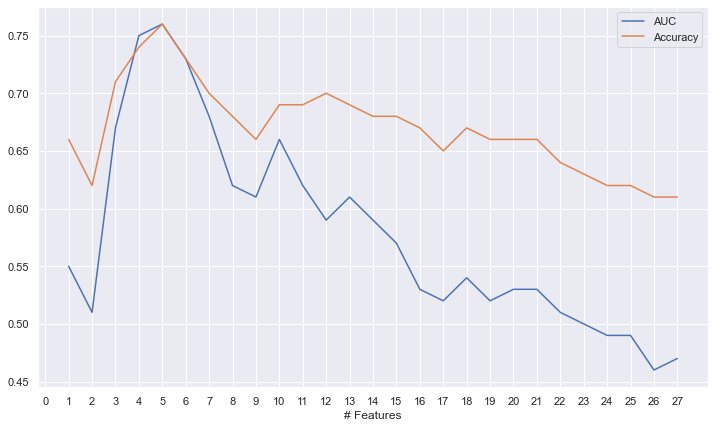

In [99]:
sns.set(rc={'figure.figsize':(12,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_shap_auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_shap_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
g.set(xlabel='# Features')

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/abs_shap_learning_curve.png",bbox_inches = "tight")

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

#### Positive SHAP Array

In [100]:
#Sort them in order of their importance
sorted_pos_shap_np=np.sort(sum_avg_shap_np_0)
sorted_pos_shap_np

array([-1.30137471e-02, -7.83143557e-03, -6.00909976e-03, -4.38493162e-03,
       -3.79127093e-03, -3.58535909e-03, -3.44659859e-03, -3.13588967e-03,
       -3.11318391e-03, -2.44221060e-03, -2.22549906e-03, -2.09921968e-03,
       -1.87444425e-03, -1.57238658e-03, -6.58703494e-04, -5.72907975e-04,
        6.91748039e-05,  1.86995954e-04,  4.63139188e-04,  7.83594624e-04,
        1.00839626e-03,  1.03287564e-03,  2.84834811e-03,  3.57076738e-03,
        4.95916973e-03,  5.44896747e-03,  1.32314497e-02])

In [101]:
#sort features by importance

features_sorted_pos_shap=[]

for i in sorted_pos_shap_np:
    print(i)
    index = np.where(sum_avg_shap_np_0 == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    features_sorted_pos_shap.append(feature_array[index[0][0]])

features_sorted_pos_shap

-0.013013747088304828
4
(endo) hypothyroidism (unspecified)
-0.007831435570189404
8
(gi) gastroesophageal reflux disease
-0.0060090997552789205
7
(gi) dysphagia
-0.00438493161921223
0
(cv) hypertension (unspecified)
-0.0037912709333467014
6
(endo) vitamin D deficiency
-0.0035853590903462715
24
(psych) post traumatic stress disorder
-0.003446598586336469
21
(psych) attention deficit hyperactivity disorder
-0.0031358896733578376
23
(psych) major depressive disorder
-0.003113183908351157
15
(neuro) migraine
-0.0024422105989722305
11
(msk) pain, knee (unspecified)
-0.0022254990635208346
5
(endo) obesity
-0.0020992196787083845
25
(resp) asthma
-0.001874444248738179
20
(psych) anxiety (unspecified)
-0.0015723865778634503
19
(ophth) diplopia
-0.0006587034943052564
3
(endo) Hashimoto's disease
-0.0005729079754131114
12
(nephro/uro) kidney disease, chronic
6.917480390506907e-05
13
(neuro) abnormal involuntary movement
0.0001869959537252657
9
(id) urinary tract infection, recurrent
0.00046313918

['(endo) hypothyroidism (unspecified)',
 '(gi) gastroesophageal reflux disease',
 '(gi) dysphagia',
 '(cv) hypertension (unspecified)',
 '(endo) vitamin D deficiency',
 '(psych) post traumatic stress disorder',
 '(psych) attention deficit hyperactivity disorder',
 '(psych) major depressive disorder',
 '(neuro) migraine',
 '(msk) pain, knee (unspecified)',
 '(endo) obesity',
 '(resp) asthma',
 '(psych) anxiety (unspecified)',
 '(ophth) diplopia',
 "(endo) Hashimoto's disease",
 '(nephro/uro) kidney disease, chronic',
 '(neuro) abnormal involuntary movement',
 '(id) urinary tract infection, recurrent',
 '(endo) dyslipidemia',
 '(neuro) peripheral neuropathy (unspecified)',
 '(endo) diabetes mellitus (unspecified)',
 '(neuro) seizure (unspecified)',
 '(resp) obstructive sleep apnea',
 '(neuro) headache (unspecified)',
 '(neuro) pain, back (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(psych) depression (unspecified)']

In [102]:
pos_shap_accuracy_array=[]
pos_shap_auc_array=[]

for i in range(len(features_sorted_pos_shap)):
    
    to_include=features_sorted_pos_shap[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    pos_shap_accuracy_array.append(accuracy)
    pos_shap_auc_array.append(auc)

(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
(msk) pain, joint (unspecified)
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accur

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.78 [0.62-0.94]

Precison: 	0.82 [0.67-0.97]

Specificity: 	0.95 [0.89-1.01]

Sensitivity: 	0.60 [0.41-0.79]

AUC: 		0.75 [0.59-0.91]
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.77 [0.60-0.94]

Precison: 	0.80 [0.64-0.96]

Specificity: 	0.91 [0.82-1.00]

Sensitivity: 	0.62 [0.43-0.81]

AUC: 		0.75 [0.59-0.91]
(endo) diabetes mellitus (unspecified)
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) seizure (unspecified)
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 7)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-0.89]

Precison: 	0.76 [0.59-0.93]

Specificity: 	0.85 [0.75-0.95]

Sensitivity: 	0.56 [0.37-0.75]

AUC: 		0.59 [0.42-0.76]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.79 [0.67-0.91]

Sensitivity: 	0.53 [0.34-0.72]

AUC: 		0.49 [0.31-0.67]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 14)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.68 [0.50-0.86]

Specificity: 	0.76 [0.62-0.90]

Sensitivity: 	0.53 [0.35-0.71]

AUC: 		0.48 [0.30-0.66]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(resp) obstructive sleep apnea
(48, 15)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.60 [0.41-0.79]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.46 [0.27-0.65]

AUC: 		0.47 [0.28-0.66]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(resp) asthma
(resp) obstructive sleep apnea
(48, 18)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.59 [0.40-0.78]

Precison: 	0.62 [0.43-0.81]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.46 [0.27-0.65]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(resp) asthma
(resp) obstructive sleep apnea
(48, 19)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.60 [0.41-0.79]

Precison: 	0.62 [0.43-0.81]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.46 [0.27-0.65]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 20)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.59 [0.40-0.78]

Precison: 	0.61 [0.42-0.80]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.43 [0.25-0.61]

AUC: 		0.45 [0.26-0.64]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 21)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.58 [0.39-0.77]

Precison: 	0.60 [0.41-0.79]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.42 [0.24-0.60]

AUC: 		0.43 [0.24-0.62]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 22)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.58 [0.39-0.77]

Precison: 	0.61 [0.42-0.80]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.43 [0.25-0.61]

AUC: 		0.44 [0.25-0.63]
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(endo) vitamin D deficiency
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 23)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.58 [0.39-0.77]

Precison: 	0.60 [0.41-0.79]

Specificity: 	0.71 [0.55-0.87]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.45 [0.26-0.64]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(endo) vitamin D deficiency
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 24)
[[0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.55 [0.35-0.75]

Precison: 	0.57 [0.38-0.76]

Specificity: 	0.70 [0.55-0.85]

Sensitivity: 	0.40 [0.22-0.58]

AUC: 		0.44 [0.25-0.63]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.58 [0.39-0.77]

Precison: 	0.60 [0.41-0.79]

Specificity: 	0.71 [0.56-0.86]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.44 [0.25-0.63]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asth

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.59 [0.40-0.78]

Precison: 	0.60 [0.41-0.79]

Specificity: 	0.72 [0.56-0.88]

Sensitivity: 	0.45 [0.27-0.63]

AUC: 		0.45 [0.26-0.64]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post t

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]


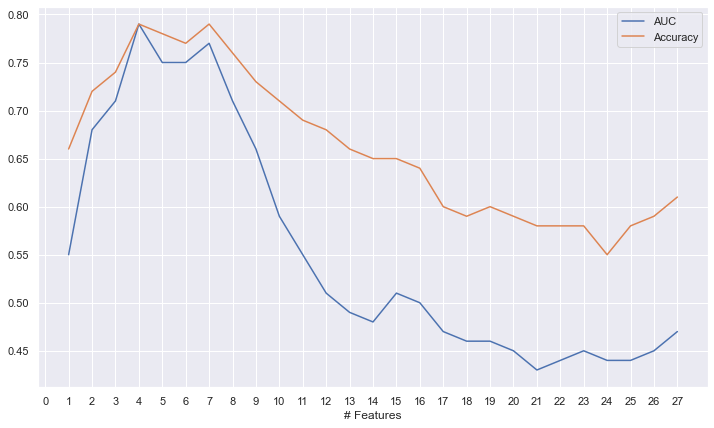

In [103]:
sns.set(rc={'figure.figsize':(12,7)})

fig, axes = plt.subplots(1, 1)


g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=pos_shap_auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=pos_shap_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
g.set(xlabel='# Features')

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/pos_shap_learning_curve.png",bbox_inches = "tight")


# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

In [92]:
features_sorted_pos_shap[:0]

[]

(endo) hypothyroidism (unspecified)
(48, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.48 [0.28-0.68]

Precison: 	0.37 [0.18-0.56]

Specificity: 	0.75 [0.65-0.85]

Sensitivity: 	0.21 [0.11-0.31]

AUC: 		0.50 [0.30-0.70]
(endo) hypothyroidism (unspecified)
(gi) gastroesophageal reflux disease
(48, 2)
[[0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.60 [0.41-0.79]

Precison: 	0.62 [0.43-0.81]

Specificity: 	0.80 [0.66-0.94]

Sensitivity: 	0.38 [0.20-0.56]

AUC: 		0.51 [0.32-0.70]
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(48, 3)
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.58 [0.38-0.78]

Precison: 	0.59 [0.40-0.78]

Specificity: 	0.71 [0.55-0.87]

Sensitivity: 	0.44 [0.26-0.62]

AUC: 		0.49 [0.30-0.68]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(48, 5)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]
 [0. 1. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.55 [0.35-0.75]

Precison: 	0.56 [0.37-0.75]

Specificity: 	0.69 [0.53-0.85]

Sensitivity: 	0.41 [0.23-0.59]

AUC: 		0.47 [0.28-0.66]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(psych) post traumatic stress disorder
(48, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.54 [0.34-0.74]

Precison: 	0.55 [0.36-0.74]

Specificity: 	0.67 [0.50-0.84]

Sensitivity: 	0.41 [0.23-0.59]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(psych) attention deficit hyperactivity disorder
(psych) post traumatic stress disorder
(48, 7)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.51 [0.32-0.70]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.36 [0.19-0.53]

AUC: 		0.47 [0.27-0.67]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.54 [0.34-0.74]

Precison: 	0.55 [0.36-0.74]

Specificity: 	0.67 [0.51-0.83]

Sensitivity: 	0.41 [0.23-0.59]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(neuro) migraine
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 9)
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.53 [0.33-0.73]

Precison: 	0.53 [0.34-0.72]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.39 [0.22-0.56]

AUC: 		0.47 [0.28-0.66]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.52 [0.32-0.72]

Precison: 	0.52 [0.33-0.71]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.37 [0.20-0.54]

AUC: 		0.47 [0.27-0.67]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.50 [0.31-0.69]

Specificity: 	0.65 [0.48-0.82]

Sensitivity: 	0.37 [0.20-0.54]

AUC: 		0.47 [0.27-0.67]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.50 [0.30-0.70]

Precison: 	0.50 [0.31-0.69]

Specificity: 	0.65 [0.48-0.82]

Sensitivity: 	0.35 [0.18-0.52]

AUC: 		0.48 [0.28-0.68]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 13)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.53 [0.33-0.73]

Precison: 	0.53 [0.34-0.72]

Specificity: 	0.68 [0.52-0.84]

Sensitivity: 	0.38 [0.21-0.55]

AUC: 		0.47 [0.27-0.67]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 14)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.55 [0.35-0.75]

Precison: 	0.55 [0.36-0.74]

Specificity: 	0.69 [0.53-0.85]

Sensitivity: 	0.41 [0.24-0.58]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 15)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.54 [0.34-0.74]

Precison: 	0.54 [0.35-0.73]

Specificity: 	0.68 [0.51-0.85]

Sensitivity: 	0.40 [0.23-0.57]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 16)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.53 [0.33-0.73]

Precison: 	0.53 [0.34-0.72]

Specificity: 	0.67 [0.50-0.84]

Sensitivity: 	0.39 [0.22-0.56]

AUC: 		0.46 [0.26-0.66]
(cv) hypertension (unspecified)
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 17)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.54 [0.34-0.74]

Precison: 	0.53 [0.34-0.72]

Specificity: 	0.66 [0.49-0.83]

Sensitivity: 	0.41 [0.24-0.58]

AUC: 		0.46 [0.27-0.65]
(cv) hypertension (unspecified)
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 18)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.53 [0.33-0.73]

Precison: 	0.53 [0.34-0.72]

Specificity: 	0.66 [0.49-0.83]

Sensitivity: 	0.40 [0.23-0.57]

AUC: 		0.45 [0.26-0.64]
(cv) hypertension (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 19)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.52 [0.32-0.72]

Precison: 	0.52 [0.33-0.71]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.38 [0.21-0.55]

AUC: 		0.44 [0.25-0.63]
(cv) hypertension (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 20)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.51 [0.32-0.70]

Specificity: 	0.64 [0.48-0.80]

Sensitivity: 	0.37 [0.20-0.54]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.52 [0.33-0.71]

Specificity: 	0.65 [0.49-0.81]

Sensitivity: 	0.37 [0.20-0.54]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 22)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.52 [0.32-0.72]

Precison: 	0.52 [0.33-0.71]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.37 [0.20-0.54]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) migraine
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.50 [0.31-0.69]

Specificity: 	0.65 [0.49-0.81]

Sensitivity: 	0.36 [0.19-0.53]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep apnea
(48, 24)
[[0. 0. 0. ... 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.51 [0.32-0.70]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.36 [0.19-0.53]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(resp) obstructive sleep a

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.51 [0.31-0.71]

Precison: 	0.51 [0.32-0.70]

Specificity: 	0.66 [0.50-0.82]

Sensitivity: 	0.35 [0.19-0.51]

AUC: 		0.45 [0.25-0.65]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) a

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.54 [0.34-0.74]

Precison: 	0.54 [0.35-0.73]

Specificity: 	0.68 [0.52-0.84]

Sensitivity: 	0.39 [0.22-0.56]

AUC: 		0.43 [0.24-0.62]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post t

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.47 [0.29-0.65]


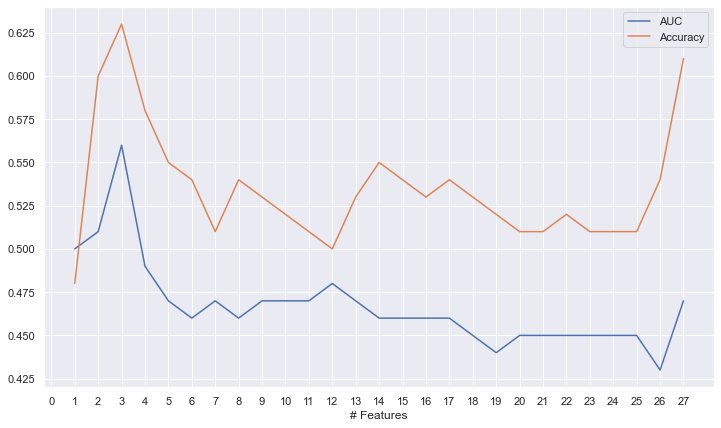

In [93]:
pos_shap_accuracy_array=[]
pos_shap_auc_array=[]

for i in range(len(features_sorted_pos_shap)):
    
    to_include=features_sorted_pos_shap[:i+1]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    pos_shap_accuracy_array.append(accuracy)
    pos_shap_auc_array.append(auc)
    
sns.set(rc={'figure.figsize':(12,7)})

g=sns.lineplot(x=np.arange(start=1, stop=28, step=1),y=pos_shap_auc_array)
g=sns.lineplot(x=np.arange(start=1, stop=28, step=1),y=pos_shap_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
g.set(xlabel='# Features')

g.legend(['AUC','Accuracy'])

# g.set_xticklabels(np.arange(start=1, stop=28, step=1))

In [63]:
absolute_shap=np.abs(sum_avg_shap_np_1)

In [58]:
sum_avg_shap_np_1,sum_avg_shap_np_0

(array([ 4.38493162e-03, -1.00839626e-03, -4.63139188e-04,  6.58703494e-04,
         1.30137471e-02,  2.22549906e-03,  3.79127093e-03,  6.00909976e-03,
         7.83143557e-03, -1.86995954e-04, -5.44896747e-03,  2.44221060e-03,
         5.72907975e-04, -6.91748039e-05, -3.57076738e-03,  3.11318391e-03,
        -4.95916973e-03, -7.83594624e-04, -1.03287564e-03,  1.57238658e-03,
         1.87444425e-03,  3.44659859e-03, -1.32314497e-02,  3.13588967e-03,
         3.58535909e-03,  2.09921968e-03, -2.84834811e-03]),
 array([-4.38493162e-03,  1.00839626e-03,  4.63139188e-04, -6.58703494e-04,
        -1.30137471e-02, -2.22549906e-03, -3.79127093e-03, -6.00909976e-03,
        -7.83143557e-03,  1.86995954e-04,  5.44896747e-03, -2.44221060e-03,
        -5.72907975e-04,  6.91748039e-05,  3.57076738e-03, -3.11318391e-03,
         4.95916973e-03,  7.83594624e-04,  1.03287564e-03, -1.57238658e-03,
        -1.87444425e-03, -3.44659859e-03,  1.32314497e-02, -3.13588967e-03,
        -3.58535909e-03, -2

In [64]:
#Sort them in order of their importance
sorted_shap_np=np.sort(absolute_shap)
sorted_shap_np

array([6.91748039e-05, 1.86995954e-04, 4.63139188e-04, 5.72907975e-04,
       6.58703494e-04, 7.83594624e-04, 1.00839626e-03, 1.03287564e-03,
       1.57238658e-03, 1.87444425e-03, 2.09921968e-03, 2.22549906e-03,
       2.44221060e-03, 2.84834811e-03, 3.11318391e-03, 3.13588967e-03,
       3.44659859e-03, 3.57076738e-03, 3.58535909e-03, 3.79127093e-03,
       4.38493162e-03, 4.95916973e-03, 5.44896747e-03, 6.00909976e-03,
       7.83143557e-03, 1.30137471e-02, 1.32314497e-02])

In [66]:
#sort features by importance

features_sorted_shap=[]

for i in sorted_shap_np:
    print(i)
    index = np.where(absolute_shap == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    features_sorted_shap.append(feature_array[index[0][0]])

features_sorted_shap

6.917480390506278e-05
13
(neuro) abnormal involuntary movement
0.00018699595372526385
9
(id) urinary tract infection, recurrent
0.00046313918821293157
2
(endo) dyslipidemia
0.0005729079754131098
12
(nephro/uro) kidney disease, chronic
0.0006587034943052691
3
(endo) Hashimoto's disease
0.0007835946243204975
17
(neuro) peripheral neuropathy (unspecified)
0.0010083962553800211
1
(endo) diabetes mellitus (unspecified)
0.0010328756439105054
18
(neuro) seizure (unspecified)
0.0015723865778634544
19
(ophth) diplopia
0.0018744442487381874
20
(psych) anxiety (unspecified)
0.0020992196787083827
25
(resp) asthma
0.0022254990635208285
5
(endo) obesity
0.002442210598972237
11
(msk) pain, knee (unspecified)
0.002848348105712256
26
(resp) obstructive sleep apnea
0.003113183908351165
15
(neuro) migraine
0.003135889673357826
23
(psych) major depressive disorder
0.003446598586336475
21
(psych) attention deficit hyperactivity disorder
0.0035707673836357936
14
(neuro) headache (unspecified)
0.003585359090

['(neuro) abnormal involuntary movement',
 '(id) urinary tract infection, recurrent',
 '(endo) dyslipidemia',
 '(nephro/uro) kidney disease, chronic',
 "(endo) Hashimoto's disease",
 '(neuro) peripheral neuropathy (unspecified)',
 '(endo) diabetes mellitus (unspecified)',
 '(neuro) seizure (unspecified)',
 '(ophth) diplopia',
 '(psych) anxiety (unspecified)',
 '(resp) asthma',
 '(endo) obesity',
 '(msk) pain, knee (unspecified)',
 '(resp) obstructive sleep apnea',
 '(neuro) migraine',
 '(psych) major depressive disorder',
 '(psych) attention deficit hyperactivity disorder',
 '(neuro) headache (unspecified)',
 '(psych) post traumatic stress disorder',
 '(endo) vitamin D deficiency',
 '(cv) hypertension (unspecified)',
 '(neuro) pain, back (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(gi) gastroesophageal reflux disease',
 '(endo) hypothyroidism (unspecified)',
 '(psych) depression (unspecified)']

In [67]:
to_include=features_sorted_shap[-1-7:]
df_refined=df.copy()

for feature in feature_array:
    if (feature in to_include):
        print(feature)
    else:
        df_refined = df_refined.T.drop(labels=feature, axis=1).T
accuracy,auc=test_data(df_refined,362)

# accuracy_array.append(accuracy)
# auc_array.append(auc)

(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(neuro) pain, back (unspecified)
(psych) depression (unspecified)
(48, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 

### Absolute Importance

In [113]:
imp_np_abs=np.abs(imp_np)

In [114]:
#Sort them in order of their importance
sorted_imp_np_abs=np.sort(imp_np_abs)
sorted_imp_np_abs

array([2.77555756e-17, 9.72222222e-03, 1.11111111e-02, 2.08333333e-02,
       3.61111111e-02, 6.66666667e-02, 8.75000000e-02, 9.16666667e-02,
       9.86111111e-02, 1.00000000e-01, 1.02777778e-01, 1.15277778e-01,
       1.22222222e-01, 1.29166667e-01, 1.37500000e-01, 1.75000000e-01,
       3.91666667e-01, 4.54166667e-01, 4.61111111e-01, 5.48611111e-01,
       5.65277778e-01, 5.94444444e-01, 6.56944444e-01, 7.48611111e-01,
       8.70833333e-01, 9.34722222e-01, 2.76805556e+00])

In [115]:
#sort features by importance

features_sorted_abs=[]

for i in sorted_imp_np_abs:
    print(i)
    index = np.where(imp_np_abs == i)
    print(index[0][0])
    print(feature_array[index[0][0]])
    print("============")
#     if (i<0):
    features_sorted_abs.append(feature_array[index[0][0]])

features_sorted_abs

2.7755575615628914e-17
15
(neuro) migraine
0.00972222222222223
26
(resp) obstructive sleep apnea
0.011111111111110964
18
(neuro) seizure (unspecified)
0.02083333333333329
16
(neuro) pain, back (unspecified)
0.03611111111111108
21
(psych) attention deficit hyperactivity disorder
0.06666666666666671
9
(id) urinary tract infection, recurrent
0.08750000000000005
25
(resp) asthma
0.09166666666666658
24
(psych) post traumatic stress disorder
0.09861111111111119
11
(msk) pain, knee (unspecified)
0.09999999999999996
6
(endo) vitamin D deficiency
0.10277777777777802
5
(endo) obesity
0.11527777777777785
3
(endo) Hashimoto's disease
0.1222222222222224
13
(neuro) abnormal involuntary movement
0.12916666666666665
19
(ophth) diplopia
0.1375000000000001
17
(neuro) peripheral neuropathy (unspecified)
0.17500000000000007
23
(psych) major depressive disorder
0.3916666666666668
12
(nephro/uro) kidney disease, chronic
0.45416666666666655
8
(gi) gastroesophageal reflux disease
0.46111111111111097
1
(endo) 

['(neuro) migraine',
 '(resp) obstructive sleep apnea',
 '(neuro) seizure (unspecified)',
 '(neuro) pain, back (unspecified)',
 '(psych) attention deficit hyperactivity disorder',
 '(id) urinary tract infection, recurrent',
 '(resp) asthma',
 '(psych) post traumatic stress disorder',
 '(msk) pain, knee (unspecified)',
 '(endo) vitamin D deficiency',
 '(endo) obesity',
 "(endo) Hashimoto's disease",
 '(neuro) abnormal involuntary movement',
 '(ophth) diplopia',
 '(neuro) peripheral neuropathy (unspecified)',
 '(psych) major depressive disorder',
 '(nephro/uro) kidney disease, chronic',
 '(gi) gastroesophageal reflux disease',
 '(endo) diabetes mellitus (unspecified)',
 '(psych) anxiety (unspecified)',
 '(endo) dyslipidemia',
 '(neuro) headache (unspecified)',
 '(cv) hypertension (unspecified)',
 '(endo) hypothyroidism (unspecified)',
 '(msk) pain, joint (unspecified)',
 '(gi) dysphagia',
 '(psych) depression (unspecified)']

In [116]:
abs_perm_accuracy_array=[]
abs_perm_auc_array=[]

for i in range(len(features_sorted_abs)):
    
    to_include=features_sorted_abs[-1-i:]
    df_refined=df.copy()

    for feature in feature_array:
        if (feature in to_include):
            print(feature)
        else:
            df_refined = df_refined.T.drop(labels=feature, axis=1).T
    accuracy,auc=test_data(df_refined,362)
    abs_perm_accuracy_array.append(accuracy)
    abs_perm_auc_array.append(auc)

(psych) depression (unspecified)
(48, 1)
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.66 [0.47-0.85]

Precison: 	0.80 [0.64-0.96]

Specificity: 	1.00 [1.00-1.00]

Sensitivity: 	0.30 [0.12-0.48]

AUC: 		0.55 [0.36-0.74]
(gi) dysphagia
(psych) depression (unspecified)
(48, 2)
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.59 [0.40-0.78]

AUC: 		0.66 [0.48-0.84]
(cv) hypertension (unspecified)
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(msk) pain, joint (unspecified)
(neuro) headache (unspecified)
(psych) depression (unspecified)
(48, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 

TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.77 [0.61-0.93]

Precison: 	0.79 [0.63-0.95]

Specificity: 	0.84 [0.71-0.97]

Sensitivity: 	0.71 [0.54-0.88]

AUC: 		0.81 [0.67-0.95]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(48, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.72 [0.54-0.90]

Precison: 	0.74 [0.57-0.91]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.65 [0.47-0.83]

AUC: 		0.71 [0.55-0.87]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 14)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.71 [0.53-0.89]

Precison: 	0.73 [0.56-0.90]

Specificity: 	0.80 [0.66-0.94]

Sensitivity: 	0.62 [0.44-0.80]

AUC: 		0.69 [0.53-0.85]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) hypothyroidism (unspecified)
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 15)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.69 [0.51-0.87]

Precison: 	0.71 [0.53-0.89]

Specificity: 	0.77 [0.62-0.92]

Sensitivity: 	0.60 [0.42-0.78]

AUC: 		0.63 [0.46-0.80]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(48, 18)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.49-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.77 [0.63-0.91]

Sensitivity: 	0.57 [0.39-0.75]

AUC: 		0.56 [0.39-0.73]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(48, 20)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.67 [0.49-0.85]

Precison: 	0.70 [0.52-0.88]

Specificity: 	0.78 [0.64-0.92]

Sensitivity: 	0.56 [0.37-0.75]

AUC: 		0.57 [0.39-0.75]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.65 [0.46-0.84]

Precison: 	0.67 [0.49-0.85]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.55 [0.37-0.73]

AUC: 		0.54 [0.36-0.72]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 22)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.64 [0.45-0.83]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.51 [0.33-0.69]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.66 [0.48-0.84]

Specificity: 	0.75 [0.60-0.90]

Sensitivity: 	0.51 [0.33-0.69]

AUC: 		0.48 [0.30-0.66]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress disorder
(resp) asthma
(48, 24)

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.52 [0.34-0.70]

AUC: 		0.49 [0.31-0.67]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress d

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.63 [0.44-0.82]

Precison: 	0.65 [0.46-0.84]

Specificity: 	0.74 [0.59-0.89]

Sensitivity: 	0.51 [0.33-0.69]

AUC: 		0.49 [0.31-0.67]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post traumatic stress d

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.64 [0.45-0.83]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.48 [0.30-0.66]
(cv) hypertension (unspecified)
(endo) diabetes mellitus (unspecified)
(endo) dyslipidemia
(endo) Hashimoto's disease
(endo) hypothyroidism (unspecified)
(endo) obesity
(endo) vitamin D deficiency
(gi) dysphagia
(gi) gastroesophageal reflux disease
(id) urinary tract infection, recurrent
(msk) pain, joint (unspecified)
(msk) pain, knee (unspecified)
(nephro/uro) kidney disease, chronic
(neuro) abnormal involuntary movement
(neuro) headache (unspecified)
(neuro) migraine
(neuro) pain, back (unspecified)
(neuro) peripheral neuropathy (unspecified)
(neuro) seizure (unspecified)
(ophth) diplopia
(psych) anxiety (unspecified)
(psych) attention deficit hyperactivity disorder
(psych) depression (unspecified)
(psych) major depressive disorder
(psych) post t

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


TEST: [ 0  1  3  4  6  8 12 15 16 19 20 21 22 25 28 30 31 35 36 37 38 41 42 46]
After 400 runs
Accuracy: 	0.61 [0.42-0.80]

Precison: 	0.63 [0.44-0.82]

Specificity: 	0.73 [0.58-0.88]

Sensitivity: 	0.49 [0.31-0.67]

AUC: 		0.48 [0.30-0.66]


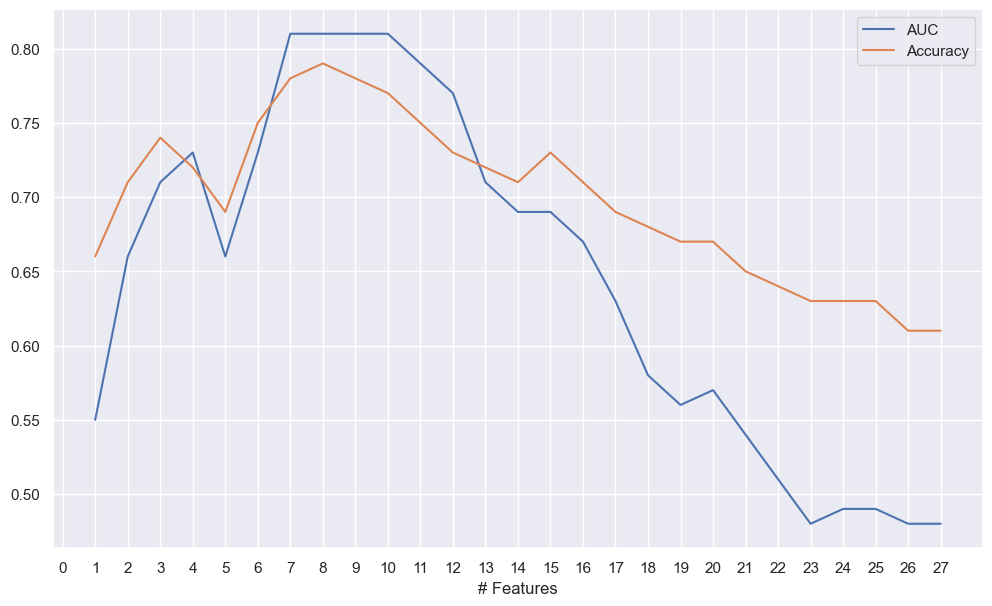

In [118]:
sns.set(rc={'figure.figsize':(12,7)})

fig, axes = plt.subplots(1, 1)

g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_auc_array)
g=sns.lineplot(ax=axes,x=np.arange(start=1, stop=28, step=1),y=abs_perm_accuracy_array)

g.set_xticks(range(np.arange(start=1, stop=29, step=1).shape[0])) # <--- set the ticks first
g.set(xlabel='# Features')

g.legend(['AUC','Accuracy'])

fig.savefig("../results/figures/abs_perm_learning_curve.png",bbox_inches = "tight")


# g.set_xticklabels(np.arange(start=1, stop=28, step=1))